In [1]:
import sys 
sys.path.insert(1, "../")
from workloads.util import use_plots, use_results

import seaborn as sns 
from matplotlib import pyplot as plt
sns.set()

import pandas as pd
%load_ext autoreload
%autoreload 2

In [2]:
sns.set_theme(style="whitegrid")
sns.set_theme(style="whitegrid", font_scale=1.7)
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

## Get STL Results 

In [3]:
data_dir = use_results("yahoo_A1_window_48_keys_67_length_700/round_robin_0_A1", download=False)
filename = f"{data_dir}/simulation_predictions.csv"
stl_df = pd.read_csv(filename)
stl_df.columns = ['ts', 'y_pred', 'y_true', 'staleness', 'key']
stl_df

,ts,y_pred,y_true,staleness,key
0,0,0.032859,0.076970,0,1
1,1,0.093368,0.063933,1,1
2,2,0.071843,0.149733,1,1
3,3,0.083161,0.041479,1,1
4,4,0.093230,0.089318,1,1
...,...,...,...,...,...
43679,647,-0.708341,1.000000,1,67
43680,648,5.499994,12.000000,1,67
43681,649,42.166662,19.000000,1,67
43682,650,25.583331,45.000000,1,67


In [178]:
stl_cache = {}

### ARIMA Model 
For some reason, this works a lot better than the regression

In [190]:
#Fit model
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, LassoCV, ElasticNet
from sklearn.metrics import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

def compute_window_error(df, W):
    unique_keys = df['key'].unique()
    results = []
    
    for key in unique_keys:
        key_df = df[df['key'] == key]

        # Iterate through the rows within the rolling window
        for i in range(W, len(key_df), W):
            window = key_df.iloc[i-W:i]

            # Check if the window has enough data points
            if len(window) < W:
                error = np.nan  # Fill with NaN if the window is too small
            else:
                error = mean_absolute_scaled_error(
                    window['y_pred'], 
                    window['y_true'], 
                    y_train=key_df.y_true
                )

            # Append the result to the list
            results.append({"key": key, "error": error, "ts": key_df.iloc[i-W]["ts"]})

    # Add the results as a new column in the original DataFrame
    return pd.DataFrame(results) 


results = []

for W in [2, 4, 8, 16, 32, 64]:
        
    error_df = compute_window_error(stl_df, 1).dropna()
    print(error_df)
        
    for offset in [0, 2, 4, 8, 16, 32, 64]: 
        
        if f"{W}_{offset}" in stl_cache: 
            results.append(stl_cache[f"{W}_{offset}"])
            continue 

        x = []
        y = []
        # Compute rolling window
        pred = []
        actual = []
        baseline = [] 
        for user_id in error_df['key'].unique()[:1]: # only for a single key 
            user_df = error_df[error_df["key"] == user_id]
            #print(user_df)
            #x += [user_df['error'].iloc[i:i+W].tolist() for i in range(len(user_df) - W - offset)]
            #y += [user_df['error'].iloc[i+W+offset].tolist() for i in range(len(user_df) - W - offset)]
            #x += [[error_df['error'].iloc[i].tolist()] for i in range(len(user_df) - offset - 1)]
            #y += [error_df['error'].iloc[i+1+offset].tolist() for i in range(len(user_df) - offset - 1)]
            
            for i in range(len(user_df) - offset - W - 1): 
                model = ARIMA(user_df['error'].iloc[i:i+W].tolist())
                model_fit = model.fit()
                forecast = model_fit.forecast(steps=offset+1)
                pred.append(forecast[-1])
                
                actual.append(user_df['error'].iloc[i+W+offset])
                baseline.append(user_df['error'].iloc[i:i+W].mean()) # use average 
                print(forecast, actual[-1])
        # Split the data into training and testing sets (50/50 split)
        #print(x, y)
        #x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

        # Initialize and fit a linear regression model
        #model = ElasticNet()
        #model.fit(x_train, y_train)


        # Make predictions on the test set
        #y_pred = model.predict(x_test)

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(pred, actual)
        #y_avg = sum(y_train) / len(y_train)
        baseline_mse = mean_squared_error(actual, baseline)
        print(offset, W, mse, "data size", len(y))
        results.append({"mse": mse, "window_size": W, "offset": offset, "key": user_id, "baseline_mse":  baseline_mse})
        stl_cache[f"{W}_{offset}"] = results[-1]


       key     error     ts
0        1  1.127618    0.0
1        1  0.752464    1.0
2        1  1.991159    2.0
3        1  1.065550    3.0
4        1  0.100017    4.0
...    ...       ...    ...
43612   67  0.448466  646.0
43613   67  0.058933  647.0
43614   67  0.224233  648.0
43615   67  0.799189  649.0
43616   67  0.669824  650.0

[43617 rows x 3 columns]
       key     error     ts
0        1  1.127618    0.0
1        1  0.752464    1.0
2        1  1.991159    2.0
3        1  1.065550    3.0
4        1  0.100017    4.0
...    ...       ...    ...
43612   67  0.448466  646.0
43613   67  0.058933  647.0
43614   67  0.224233  648.0
43615   67  0.799189  649.0
43616   67  0.669824  650.0

[43617 rows x 3 columns]
       key     error     ts
0        1  1.127618    0.0
1        1  0.752464    1.0
2        1  1.991159    2.0
3        1  1.065550    3.0
4        1  0.100017    4.0
...    ...       ...    ...
43612   67  0.448466  646.0
43613   67  0.058933  647.0
43614   67  0.224233  64

[1.30013389] 0.9137251555566531
[1.28691526] 1.0946751551855423
[1.29885544] 0.029836573927243978
[1.27111404] 0.29933651354308183
[1.26312928] 0.7398944052977039
[1.25184824] 2.3172121160271653
[1.2814417] 0.4153420945329836
[1.28026569] 1.1092923002467305
[1.29174551] 2.137915649800072
[1.26594259] 1.7413291582054966
[1.28928563] 1.7041491516075475
[1.2526251] 3.627669975266676
[1.30525821] 2.304946814251517
[1.31864302] 0.2567714652940166
[1.31484927] 0.5906595164304989
[1.2977571] 0.7442704943055507
[1.29172953] 1.0180504153547139
[1.28595668] 0.38096793056564376
[1.27881451] 0.17940394318460767
[1.28065478] 2.146708043759864
[1.30178413] 0.14808487783163432
[1.30155506] 1.65898283762447
[1.29618653] 0.8386471696843588
[1.2548626] 3.3376598534126005
[1.29895898] 0.1390761938588474
[1.28845555] 2.673217684917388
[1.30118579] 0.009064605050925175
[1.29609282] 0.049954402180564614
[1.27335988] 1.9968493013115325
[1.29382302] 1.9665899862615959
[1.30351688] 0.5614018711102551
[1.292944

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0.86089527] 1.755951047323891
[0.88161314] 0.7439019406739915
[0.88727272] 0.4001973234441858
[0.86061907] 1.102319360051958
[0.86363662] 1.2719727023069274
[0.88194244] 1.5544972511379795
[0.88088459] 0.06566469543320493
[0.86018026] 0.6935025186736226
[0.86168089] 0.2130472831042668
[0.85300496] 0.5596615294135103
[0.84295034] 0.38736167193988125
[0.84479243] 0.12602018370468604
[0.82901947] 0.11200737690903692
[0.80644188] 1.0257969996874368
[0.78772465] 1.1266833544146706
[0.78205394] 0.5469289932561863
[0.78221403] 0.3211891565082636
[0.78118879] 0.9595728602861866
[0.79040958] 1.4987965621649137
[0.81129825] 0.9311630046255601
[0.81582784] 2.2449132506361
[0.8487537] 0.08263641073942556
[0.818143] 1.114238719749668
[0.83093978] 0.26443008928117073
[0.81266225] 0.12006007880644383
[0.7891294] 0.13323805043149675
[0.77435781] 0.1889892410824559
[0.77612671] 0.7662243408573646
[0.78480371] 0.6644415712339545
[0.79463193] 2.333509781638909
[0.8111636] 0.9413756906842607
[0.80914319]

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0.97227056] 0.8751720311170261
[0.98324973] 1.5278425609957376
[0.96623282] 0.5344037224273938
[0.97289422] 0.19628334463656327
[0.96897982] 1.0985946969240399
[0.96660017] 0.1945838670795116
[0.96172238] 0.1414135779402062
[0.95946532] 1.0614946893349855
[0.97351988] 0.7437937520384481
[0.96537735] 1.3687203810268282
[0.95690663] 0.28554706870776864
[0.93117872] 0.7322100317570895
[0.92453542] 1.6537224873680736
[0.9341723] 0.525250052885523
[0.93269656] 2.8387606339310105
[0.95222602] 1.4373943229654191
[0.97108974] 0.16624897993550677
[0.95915925] 4.0481046879943845
[1.00260984] 0.3075349048303217
[0.99999322] 1.1601143284119289
[0.99284525] 2.0073955857691033
[1.00082905] 0.5310468936264645
[0.99804156] 0.19734153166687635
[0.97528711] 3.3770085232288247
[1.02186603] 1.2592297821780511
[1.02720394] 0.1175806092122772
[0.98250425] 0.17620715356701822
[0.97871195] 1.0857548541279949
[0.98517988] 0.05452356005699771
[0.96940628] 1.0338884966468778
[0.97376513] 1.1706462201169638
[0.9

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0.92410416] 1.6994517175573376
[0.93202485] 0.4073664173136336
[0.90701698] 1.6398972855099392
[0.92986591] 1.47168814932884
[0.95060255] 3.135086706881292
[0.9901876] 1.7709335580468601
[1.00896523] 0.5669673616814207
[1.00453572] 2.260442566226076
[1.03876004] 0.07332755891951792
[1.03807802] 1.220713144677983
[1.03255564] 1.5610608239540351
[1.03956514] 0.28098156960859727
[1.01851502] 0.30585945853580926
[0.98663759] 1.4830018345811857
[0.99979302] 3.558313211422807
[1.04652417] 2.1730069886605983
[1.05770614] 1.2147110594799342
[1.05563872] 3.261318681915221
[1.10308481] 0.2198217937474698
[1.09915386] 0.0747326406558597
[1.0902847] 1.9514694068832648
[1.11343554] 0.5921070292954014
[1.10455517] 1.1286463497626988
[1.10847816] 0.3646343377949581
[1.11080304] 0.20230739163283015
[1.09471403] 3.2742288658037983
[1.13755536] 1.8915050326199978
[1.15319284] 0.3297764544135213
[1.14467105] 1.1876544398757645
[1.13935561] 0.752347687800884
[1.14276097] 2.4452161525274545
[1.17790056] 1

[1.1131433 1.1131433 1.1131433] 0.5071235981205704
[1.11053191 1.11053191 1.11053191] 1.4171398624258786
[1.07393776 1.07393776 1.07393776] 0.4726571442419985
[1.07427294 1.07427294 1.07427294] 0.6489588840642337
[1.09294468 1.09294468 1.09294468] 0.5444684532869393
[1.09849605 1.09849605 1.09849605] 0.4244875006529205
[1.10166199 1.10166199 1.10166199] 0.12506192440511812
[1.09524885 1.09524885 1.09524885] 1.8228233203666957
[1.08821159 1.08821159 1.08821159] 0.6141759425435256
[1.08806547 1.08806547 1.08806547] 0.16220448685469405
[1.11608586 1.11608586 1.11608586] 2.50336316771216
[1.09961997 1.09961997 1.09961997] 3.758773940347295
[1.06912637 1.06912637 1.06912637] 2.9413088375355887
[1.09812823 1.09812823 1.09812823] 1.36826505534009
[1.12860749 1.12860749 1.12860749] 0.24298423698425606
[1.16595684 1.16595684 1.16595684] 1.4615211567010475
[1.18635709 1.18635709 1.18635709] 0.567929519867271
[1.18855675 1.18855675 1.18855675] 2.8666405671526825
[1.17755758 1.17755758 1.17755758]

[1.37096373 1.37096373 1.37096373] 1.6886744971163485
[1.3618057 1.3618057 1.3618057] 1.8031206010146186
[1.35819912 1.35819912 1.35819912] 2.3274512810127472
[1.33668089 1.33668089 1.33668089] 0.05159382382321207
[1.33562751 1.33562751 1.33562751] 0.0043865086922382345
[1.33514877 1.33514877 1.33514877] 1.7541608324511035
[1.32167819 1.32167819 1.32167819] 0.2993301869892285
[1.30464239 1.30464239 1.30464239] 1.2704193597006113
[1.331585 1.331585 1.331585] 1.2564629627558177
[1.3315849 1.3315849 1.3315849] 0.6982086320585784
[1.33987443 1.33987443 1.33987443] 0.970283990020753
[1.32329993 1.32329993 1.32329993] 1.4639248078605576
[1.32771971 1.32771971 1.32771971] 0.6587337499968444
[1.32554771 1.32554771 1.32554771] 0.1453344474809909
[1.3150166 1.3150166 1.3150166] 0.8488684717470268
[1.29810105 1.29810105 1.29810105] 2.7500078516809023
[1.27374458 1.27374458 1.27374458] 1.2197013466275604
[1.23032588 1.23032588 1.23032588] 4.977646257883583
[1.23727998 1.23727998 1.23727998] 0.4300

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0.85300496 0.85300496 0.85300496] 0.12602018370468604
[0.84295034 0.84295034 0.84295034] 0.11200737690903692
[0.84479243 0.84479243 0.84479243] 1.0257969996874368
[0.82901947 0.82901947 0.82901947] 1.1266833544146706
[0.80644188 0.80644188 0.80644188] 0.5469289932561863
[0.78772465 0.78772465 0.78772465] 0.3211891565082636
[0.78205394 0.78205394 0.78205394] 0.9595728602861866
[0.78221403 0.78221403 0.78221403] 1.4987965621649137
[0.78118879 0.78118879 0.78118879] 0.9311630046255601
[0.79040958 0.79040958 0.79040958] 2.2449132506361
[0.81129825 0.81129825 0.81129825] 0.08263641073942556
[0.81582784 0.81582784 0.81582784] 1.114238719749668
[0.8487537 0.8487537 0.8487537] 0.26443008928117073
[0.818143 0.818143 0.818143] 0.12006007880644383
[0.83093978 0.83093978 0.83093978] 0.13323805043149675
[0.81266225 0.81266225 0.81266225] 0.1889892410824559
[0.7891294 0.7891294 0.7891294] 0.7662243408573646
[0.77435781 0.77435781 0.77435781] 0.6644415712339545
[0.77612671 0.77612671 0.77612671] 2.3

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0.97227056 0.97227056 0.97227056] 0.5344037224273938
[0.98324973 0.98324973 0.98324973] 0.19628334463656327
[0.96623282 0.96623282 0.96623282] 1.0985946969240399
[0.97289422 0.97289422 0.97289422] 0.1945838670795116
[0.96897982 0.96897982 0.96897982] 0.1414135779402062
[0.96660017 0.96660017 0.96660017] 1.0614946893349855
[0.96172238 0.96172238 0.96172238] 0.7437937520384481
[0.95946532 0.95946532 0.95946532] 1.3687203810268282
[0.97351988 0.97351988 0.97351988] 0.28554706870776864
[0.96537735 0.96537735 0.96537735] 0.7322100317570895
[0.95690663 0.95690663 0.95690663] 1.6537224873680736
[0.93117872 0.93117872 0.93117872] 0.525250052885523
[0.92453542 0.92453542 0.92453542] 2.8387606339310105
[0.9341723 0.9341723 0.9341723] 1.4373943229654191
[0.93269656 0.93269656 0.93269656] 0.16624897993550677
[0.95222602 0.95222602 0.95222602] 4.0481046879943845
[0.97108974 0.97108974 0.97108974] 0.3075349048303217
[0.95915925 0.95915925 0.95915925] 1.1601143284119289
[1.00260984 1.00260984 1.0026

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0.93711682 0.93711682 0.93711682] 0.4073664173136336
[0.92410416 0.92410416 0.92410416] 1.6398972855099392
[0.93202485 0.93202485 0.93202485] 1.47168814932884
[0.90701698 0.90701698 0.90701698] 3.135086706881292
[0.92986591 0.92986591 0.92986591] 1.7709335580468601
[0.95060255 0.95060255 0.95060255] 0.5669673616814207
[0.9901876 0.9901876 0.9901876] 2.260442566226076
[1.00896523 1.00896523 1.00896523] 0.07332755891951792
[1.00453572 1.00453572 1.00453572] 1.220713144677983
[1.03876004 1.03876004 1.03876004] 1.5610608239540351
[1.03807802 1.03807802 1.03807802] 0.28098156960859727
[1.03255564 1.03255564 1.03255564] 0.30585945853580926
[1.03956514 1.03956514 1.03956514] 1.4830018345811857
[1.01851502 1.01851502 1.01851502] 3.558313211422807
[0.98663759 0.98663759 0.98663759] 2.1730069886605983
[0.99979302 0.99979302 0.99979302] 1.2147110594799342
[1.04652417 1.04652417 1.04652417] 3.261318681915221
[1.05770614 1.05770614 1.05770614] 0.2198217937474698
[1.05563872 1.05563872 1.05563872] 

[1.05778685 1.05778685 1.05778685 1.05778685 1.05778685] 0.550941924087626
[1.078826 1.078826 1.078826 1.078826 1.078826] 0.0626548747946661
[1.07319759 1.07319759 1.07319759 1.07319759 1.07319759] 0.1022105472929747
[1.06553127 1.06553127 1.06553127 1.06553127 1.06553127] 2.165472416552871
[1.08967551 1.08967551 1.08967551 1.08967551 1.08967551] 0.26083185947476123
[1.09026222 1.09026222 1.09026222 1.09026222 1.09026222] 2.882420765482324
[1.08095489 1.08095489 1.08095489 1.08095489 1.08095489] 0.8212418129522528
[1.02835926 1.02835926 1.02835926 1.02835926 1.02835926] 2.2948204556174425
[1.05894163 1.05894163 1.05894163 1.05894163 1.05894163] 0.45694589085273885
[1.03112839 1.03112839 1.03112839 1.03112839 1.03112839] 0.03924384682144829
[1.06226979 1.06226979 1.06226979 1.06226979 1.06226979] 0.7533734657055364
[1.04723096 1.04723096 1.04723096 1.04723096 1.04723096] 1.782130135115767
[1.06361309 1.06361309 1.06361309 1.06361309 1.06361309] 0.4321494262111388
[1.06733441 1.06733441 

[1.18031206 1.18031206 1.18031206 1.18031206 1.18031206] 3.483375065673814
[1.15149771 1.15149771 1.15149771 1.15149771 1.15149771] 0.5154938707590776
[1.11848617 1.11848617 1.11848617 1.11848617 1.11848617] 0.8112968855876622
[1.0928753 1.0928753 1.0928753 1.0928753 1.0928753] 1.858475260004336
[1.12197546 1.12197546 1.12197546 1.12197546 1.12197546] 0.33501441415609273
[1.17500591 1.17500591 1.17500591 1.17500591 1.17500591] 1.5048628592477624
[1.17747275 1.17747275 1.17747275 1.17747275 1.17747275] 0.68720879836584
[1.18911607 1.18911607 1.18911607 1.18911607 1.18911607] 1.3461919764647203
[1.20408519 1.20408519 1.20408519 1.20408519 1.20408519] 1.2380187428147431
[1.19348893 1.19348893 1.19348893 1.19348893 1.19348893] 1.2134502908727378
[1.2090786 1.2090786 1.2090786 1.2090786 1.2090786] 0.17037129423425168
[1.19767343 1.19767343 1.19767343 1.19767343 1.19767343] 1.2630042768602272
[1.21132243 1.21132243 1.21132243 1.21132243 1.21132243] 2.183008866278526
[1.22052649 1.22052649 1.

[1.3315849 1.3315849 1.3315849 1.3315849 1.3315849] 1.4639248078605576
[1.33987443 1.33987443 1.33987443 1.33987443 1.33987443] 0.6587337499968444
[1.32329993 1.32329993 1.32329993 1.32329993 1.32329993] 0.1453344474809909
[1.32771971 1.32771971 1.32771971 1.32771971 1.32771971] 0.8488684717470268
[1.32554771 1.32554771 1.32554771 1.32554771 1.32554771] 2.7500078516809023
[1.3150166 1.3150166 1.3150166 1.3150166 1.3150166] 1.2197013466275604
[1.29810105 1.29810105 1.29810105 1.29810105 1.29810105] 4.977646257883583
[1.27374458 1.27374458 1.27374458 1.27374458 1.27374458] 0.4300074273542371
[1.23032588 1.23032588 1.23032588 1.23032588 1.23032588] 0.38168856820461355
[1.23727998 1.23727998 1.23727998 1.23727998 1.23727998] 2.1060275161594455
[1.25232574 1.25232574 1.25232574 1.25232574 1.25232574] 0.9091962080071742
[1.32087247 1.32087247 1.32087247 1.32087247 1.32087247] 0.10041045042976454
[1.31596211 1.31596211 1.31596211 1.31596211 1.31596211] 1.6221917805288604
[1.30601896 1.3060189

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0.88088459 0.88088459 0.88088459 0.88088459 0.88088459] 0.38736167193988125
[0.86018026 0.86018026 0.86018026 0.86018026 0.86018026] 0.12602018370468604
[0.86168089 0.86168089 0.86168089 0.86168089 0.86168089] 0.11200737690903692
[0.85300496 0.85300496 0.85300496 0.85300496 0.85300496] 1.0257969996874368
[0.84295034 0.84295034 0.84295034 0.84295034 0.84295034] 1.1266833544146706
[0.84479243 0.84479243 0.84479243 0.84479243 0.84479243] 0.5469289932561863
[0.82901947 0.82901947 0.82901947 0.82901947 0.82901947] 0.3211891565082636
[0.80644188 0.80644188 0.80644188 0.80644188 0.80644188] 0.9595728602861866
[0.78772465 0.78772465 0.78772465 0.78772465 0.78772465] 1.4987965621649137
[0.78205394 0.78205394 0.78205394 0.78205394 0.78205394] 0.9311630046255601
[0.78221403 0.78221403 0.78221403 0.78221403 0.78221403] 2.2449132506361
[0.78118879 0.78118879 0.78118879 0.78118879 0.78118879] 0.08263641073942556
[0.79040958 0.79040958 0.79040958 0.79040958 0.79040958] 1.114238719749668
[0.81129825 

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0.96437192 0.96437192 0.96437192 0.96437192 0.96437192] 0.19628334463656327
[0.97227056 0.97227056 0.97227056 0.97227056 0.97227056] 1.0985946969240399
[0.98324973 0.98324973 0.98324973 0.98324973 0.98324973] 0.1945838670795116
[0.96623282 0.96623282 0.96623282 0.96623282 0.96623282] 0.1414135779402062
[0.97289422 0.97289422 0.97289422 0.97289422 0.97289422] 1.0614946893349855
[0.96897982 0.96897982 0.96897982 0.96897982 0.96897982] 0.7437937520384481
[0.96660017 0.96660017 0.96660017 0.96660017 0.96660017] 1.3687203810268282
[0.96172238 0.96172238 0.96172238 0.96172238 0.96172238] 0.28554706870776864
[0.95946532 0.95946532 0.95946532 0.95946532 0.95946532] 0.7322100317570895
[0.97351988 0.97351988 0.97351988 0.97351988 0.97351988] 1.6537224873680736
[0.96537735 0.96537735 0.96537735 0.96537735 0.96537735] 0.525250052885523
[0.95690663 0.95690663 0.95690663 0.95690663 0.95690663] 2.8387606339310105
[0.93117872 0.93117872 0.93117872 0.93117872 0.93117872] 1.4373943229654191
[0.92453542

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0.93711682 0.93711682 0.93711682 0.93711682 0.93711682] 1.47168814932884
[0.92410416 0.92410416 0.92410416 0.92410416 0.92410416] 3.135086706881292
[0.93202485 0.93202485 0.93202485 0.93202485 0.93202485] 1.7709335580468601
[0.90701698 0.90701698 0.90701698 0.90701698 0.90701698] 0.5669673616814207
[0.92986591 0.92986591 0.92986591 0.92986591 0.92986591] 2.260442566226076
[0.95060255 0.95060255 0.95060255 0.95060255 0.95060255] 0.07332755891951792
[0.9901876 0.9901876 0.9901876 0.9901876 0.9901876] 1.220713144677983
[1.00896523 1.00896523 1.00896523 1.00896523 1.00896523] 1.5610608239540351
[1.00453572 1.00453572 1.00453572 1.00453572 1.00453572] 0.28098156960859727
[1.03876004 1.03876004 1.03876004 1.03876004 1.03876004] 0.30585945853580926
[1.03807802 1.03807802 1.03807802 1.03807802 1.03807802] 1.4830018345811857
[1.03255564 1.03255564 1.03255564 1.03255564 1.03255564] 3.558313211422807
[1.03956514 1.03956514 1.03956514 1.03956514 1.03956514] 2.1730069886605983
[1.01851502 1.018515

[1.04326954 1.04326954 1.04326954 1.04326954 1.04326954 1.04326954
 1.04326954 1.04326954 1.04326954] 0.6469024680086851
[1.05538557 1.05538557 1.05538557 1.05538557 1.05538557 1.05538557
 1.05538557 1.05538557 1.05538557] 0.737132582074544
[1.06556142 1.06556142 1.06556142 1.06556142 1.06556142 1.06556142
 1.06556142 1.06556142 1.06556142] 1.0675808946629985
[1.0655322 1.0655322 1.0655322 1.0655322 1.0655322 1.0655322 1.0655322
 1.0655322 1.0655322] 3.355197802937128
[1.0927697 1.0927697 1.0927697 1.0927697 1.0927697 1.0927697 1.0927697
 1.0927697 1.0927697] 0.48567209438525494
[1.09722129 1.09722129 1.09722129 1.09722129 1.09722129 1.09722129
 1.09722129 1.09722129 1.09722129] 0.22214842916140887
[1.09567126 1.09567126 1.09567126 1.09567126 1.09567126 1.09567126
 1.09567126 1.09567126 1.09567126] 0.11736923542003334
[1.07797797 1.07797797 1.07797797 1.07797797 1.07797797 1.07797797
 1.07797797 1.07797797 1.07797797] 0.44633870905825646
[1.07128527 1.07128527 1.07128527 1.07128527 1.0

[1.12814766 1.12814766 1.12814766 1.12814766 1.12814766 1.12814766
 1.12814766 1.12814766 1.12814766] 0.5444684532869393
[1.12362769 1.12362769 1.12362769 1.12362769 1.12362769 1.12362769
 1.12362769 1.12362769 1.12362769] 0.4244875006529205
[1.1131433 1.1131433 1.1131433 1.1131433 1.1131433 1.1131433 1.1131433
 1.1131433 1.1131433] 0.12506192440511812
[1.11053191 1.11053191 1.11053191 1.11053191 1.11053191 1.11053191
 1.11053191 1.11053191 1.11053191] 1.8228233203666957
[1.07393776 1.07393776 1.07393776 1.07393776 1.07393776 1.07393776
 1.07393776 1.07393776 1.07393776] 0.6141759425435256
[1.07427294 1.07427294 1.07427294 1.07427294 1.07427294 1.07427294
 1.07427294 1.07427294 1.07427294] 0.16220448685469405
[1.09294468 1.09294468 1.09294468 1.09294468 1.09294468 1.09294468
 1.09294468 1.09294468 1.09294468] 2.50336316771216
[1.09849605 1.09849605 1.09849605 1.09849605 1.09849605 1.09849605
 1.09849605 1.09849605 1.09849605] 3.758773940347295
[1.10166199 1.10166199 1.10166199 1.101661

[1.2090786 1.2090786 1.2090786 1.2090786 1.2090786 1.2090786 1.2090786
 1.2090786 1.2090786] 1.6375445628952339
[1.19767343 1.19767343 1.19767343 1.19767343 1.19767343 1.19767343
 1.19767343 1.19767343 1.19767343] 3.8079898589930496
[1.21132243 1.21132243 1.21132243 1.21132243 1.21132243 1.21132243
 1.21132243 1.21132243 1.21132243] 2.9741031075187085
[1.22052649 1.22052649 1.22052649 1.22052649 1.22052649 1.22052649
 1.22052649 1.22052649 1.22052649] 0.7495591352902423
[1.23097933 1.23097933 1.23097933 1.23097933 1.23097933 1.23097933
 1.23097933 1.23097933 1.23097933] 0.48897587000317777
[1.22700876 1.22700876 1.22700876 1.22700876 1.22700876 1.22700876
 1.22700876 1.22700876 1.22700876] 0.7005757646036396
[1.24478914 1.24478914 1.24478914 1.24478914 1.24478914 1.24478914
 1.24478914 1.24478914 1.24478914] 0.6108238800811313
[1.25041704 1.25041704 1.25041704 1.25041704 1.25041704 1.25041704
 1.25041704 1.25041704 1.25041704] 0.4477986083190429
[1.24887937 1.24887937 1.24887937 1.2488

[1.33030445 1.33030445 1.33030445 1.33030445 1.33030445 1.33030445
 1.33030445 1.33030445 1.33030445] 1.6343238579612813
[1.27572207 1.27572207 1.27572207 1.27572207 1.27572207 1.27572207
 1.27572207 1.27572207 1.27572207] 2.6178855540443777
[1.25794278 1.25794278 1.25794278 1.25794278 1.25794278 1.25794278
 1.25794278 1.25794278 1.25794278] 0.33591211013451727
[1.27067974 1.27067974 1.27067974 1.27067974 1.27067974 1.27067974
 1.27067974 1.27067974 1.27067974] 2.3855621638932383
[1.26919841 1.26919841 1.26919841 1.26919841 1.26919841 1.26919841
 1.26919841 1.26919841 1.26919841] 0.5183155248149142
[1.26756977 1.26756977 1.26756977 1.26756977 1.26756977 1.26756977
 1.26756977 1.26756977 1.26756977] 0.37448989681838224
[1.28436809 1.28436809 1.28436809 1.28436809 1.28436809 1.28436809
 1.28436809 1.28436809 1.28436809] 0.9602586403978811
[1.28313424 1.28313424 1.28313424 1.28313424 1.28313424 1.28313424
 1.28313424 1.28313424 1.28313424] 0.5811382860559429
[1.29970274 1.29970274 1.29970

[1.18908512 1.18908512 1.18908512 1.18908512 1.18908512 1.18908512
 1.18908512 1.18908512 1.18908512] 1.5439708374039054
[1.18387626 1.18387626 1.18387626 1.18387626 1.18387626 1.18387626
 1.18387626 1.18387626 1.18387626] 2.35523883026831
[1.17995113 1.17995113 1.17995113 1.17995113 1.17995113 1.17995113
 1.17995113 1.17995113 1.17995113] 0.7077160059712654
[1.17114296 1.17114296 1.17114296 1.17114296 1.17114296 1.17114296
 1.17114296 1.17114296 1.17114296] 1.2223306848851605
[1.14819895 1.14819895 1.14819895 1.14819895 1.14819895 1.14819895
 1.14819895 1.14819895 1.14819895] 0.9496228864794521
[1.14824406 1.14824406 1.14824406 1.14824406 1.14824406 1.14824406
 1.14824406 1.14824406 1.14824406] 0.0008218784265411784
[1.12294857 1.12294857 1.12294857 1.12294857 1.12294857 1.12294857
 1.12294857 1.12294857 1.12294857] 0.8080060178834672
[1.12145036 1.12145036 1.12145036 1.12145036 1.12145036 1.12145036
 1.12145036 1.12145036 1.12145036] 0.9204924110230666
[1.14579131 1.14579131 1.145791

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0.86061907 0.86061907 0.86061907 0.86061907 0.86061907 0.86061907
 0.86061907 0.86061907 0.86061907] 0.12602018370468604
[0.86363662 0.86363662 0.86363662 0.86363662 0.86363662 0.86363662
 0.86363662 0.86363662 0.86363662] 0.11200737690903692
[0.88194244 0.88194244 0.88194244 0.88194244 0.88194244 0.88194244
 0.88194244 0.88194244 0.88194244] 1.0257969996874368
[0.88088459 0.88088459 0.88088459 0.88088459 0.88088459 0.88088459
 0.88088459 0.88088459 0.88088459] 1.1266833544146706
[0.86018026 0.86018026 0.86018026 0.86018026 0.86018026 0.86018026
 0.86018026 0.86018026 0.86018026] 0.5469289932561863
[0.86168089 0.86168089 0.86168089 0.86168089 0.86168089 0.86168089
 0.86168089 0.86168089 0.86168089] 0.3211891565082636
[0.85300496 0.85300496 0.85300496 0.85300496 0.85300496 0.85300496
 0.85300496 0.85300496 0.85300496] 0.9595728602861866
[0.84295034 0.84295034 0.84295034 0.84295034 0.84295034 0.84295034
 0.84295034 0.84295034 0.84295034] 1.4987965621649137
[0.84479243 0.84479243 0.84479

[0.99192049 0.99192049 0.99192049 0.99192049 0.99192049 0.99192049
 0.99192049 0.99192049 0.99192049] 1.1124532550060295
[0.97127626 0.97127626 0.97127626 0.97127626 0.97127626 0.97127626
 0.97127626 0.97127626 0.97127626] 1.6281890410137543
[0.95898532 0.95898532 0.95898532 0.95898532 0.95898532 0.95898532
 0.95898532 0.95898532 0.95898532] 2.3460135217231475
[0.93330921 0.93330921 0.93330921 0.93330921 0.93330921 0.93330921
 0.93330921 0.93330921 0.93330921] 0.6410575216121142
[0.94091127 0.94091127 0.94091127 0.94091127 0.94091127 0.94091127
 0.94091127 0.94091127 0.94091127] 0.5675106743226945
[0.93678966 0.93678966 0.93678966 0.93678966 0.93678966 0.93678966
 0.93678966 0.93678966 0.93678966] 1.4573636824862406
[0.93375301 0.93375301 0.93375301 0.93375301 0.93375301 0.93375301
 0.93375301 0.93375301 0.93375301] 1.3470260517464538
[0.93370483 0.93370483 0.93370483 0.93370483 0.93370483 0.93370483
 0.93370483 0.93370483 0.93370483] 0.22477877360590576
[0.95621901 0.95621901 0.956219

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0.95849232 0.95849232 0.95849232 0.95849232 0.95849232 0.95849232
 0.95849232 0.95849232 0.95849232] 0.1414135779402062
[0.96437192 0.96437192 0.96437192 0.96437192 0.96437192 0.96437192
 0.96437192 0.96437192 0.96437192] 1.0614946893349855
[0.97227056 0.97227056 0.97227056 0.97227056 0.97227056 0.97227056
 0.97227056 0.97227056 0.97227056] 0.7437937520384481
[0.98324973 0.98324973 0.98324973 0.98324973 0.98324973 0.98324973
 0.98324973 0.98324973 0.98324973] 1.3687203810268282
[0.96623282 0.96623282 0.96623282 0.96623282 0.96623282 0.96623282
 0.96623282 0.96623282 0.96623282] 0.28554706870776864
[0.97289422 0.97289422 0.97289422 0.97289422 0.97289422 0.97289422
 0.97289422 0.97289422 0.97289422] 0.7322100317570895
[0.96897982 0.96897982 0.96897982 0.96897982 0.96897982 0.96897982
 0.96897982 0.96897982 0.96897982] 1.6537224873680736
[0.96660017 0.96660017 0.96660017 0.96660017 0.96660017 0.96660017
 0.96660017 0.96660017 0.96660017] 0.525250052885523
[0.96172238 0.96172238 0.9617223

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0.97079361 0.97079361 0.97079361 0.97079361 0.97079361 0.97079361
 0.97079361 0.97079361 0.97079361] 1.47168814932884
[0.97609524 0.97609524 0.97609524 0.97609524 0.97609524 0.97609524
 0.97609524 0.97609524 0.97609524] 3.135086706881292
[0.96161736 0.96161736 0.96161736 0.96161736 0.96161736 0.96161736
 0.96161736 0.96161736 0.96161736] 1.7709335580468601
[0.94604513 0.94604513 0.94604513 0.94604513 0.94604513 0.94604513
 0.94604513 0.94604513 0.94604513] 0.5669673616814207
[0.93711682 0.93711682 0.93711682 0.93711682 0.93711682 0.93711682
 0.93711682 0.93711682 0.93711682] 2.260442566226076
[0.92410416 0.92410416 0.92410416 0.92410416 0.92410416 0.92410416
 0.92410416 0.92410416 0.92410416] 0.07332755891951792
[0.93202485 0.93202485 0.93202485 0.93202485 0.93202485 0.93202485
 0.93202485 0.93202485 0.93202485] 1.220713144677983
[0.90701698 0.90701698 0.90701698 0.90701698 0.90701698 0.90701698
 0.90701698 0.90701698 0.90701698] 1.5610608239540351
[0.92986591 0.92986591 0.92986591 0.

[1.37438892 1.37438892 1.37438892 1.37438892 1.37438892 1.37438892
 1.37438892 1.37438892 1.37438892] 1.3069724356942565
[1.33008875 1.33008875 1.33008875 1.33008875 1.33008875 1.33008875
 1.33008875 1.33008875 1.33008875] 1.6720971350529041
[1.33914559 1.33914559 1.33914559 1.33914559 1.33914559 1.33914559
 1.33914559 1.33914559 1.33914559] 0.6728499125743851
[1.35893768 1.35893768 1.35893768 1.35893768 1.35893768 1.35893768
 1.35893768 1.35893768 1.35893768] 3.3518377973507967
[1.33524056 1.33524056 1.33524056 1.33524056 1.33524056 1.33524056
 1.33524056 1.33524056 1.33524056] 0.669200250824732
[1.35526997 1.35526997 1.35526997 1.35526997 1.35526997 1.35526997
 1.35526997 1.35526997 1.35526997] 3.629451297338284
[1.33749124 1.33749124 1.33749124 1.33749124 1.33749124 1.33749124
 1.33749124 1.33749124 1.33749124] 3.2651457748650987
[1.3557903 1.3557903 1.3557903 1.3557903 1.3557903 1.3557903 1.3557903
 1.3557903 1.3557903] 4.107754241249746
[1.40051969 1.40051969 1.40051969 1.40051969

[1.0575399 1.0575399 1.0575399 1.0575399 1.0575399 1.0575399 1.0575399
 1.0575399 1.0575399 1.0575399 1.0575399 1.0575399 1.0575399 1.0575399
 1.0575399 1.0575399 1.0575399] 0.03924384682144829
[1.06285096 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096
 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096
 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096] 0.7533734657055364
[1.06137638 1.06137638 1.06137638 1.06137638 1.06137638 1.06137638
 1.06137638 1.06137638 1.06137638 1.06137638 1.06137638 1.06137638
 1.06137638 1.06137638 1.06137638 1.06137638 1.06137638] 1.782130135115767
[1.05778685 1.05778685 1.05778685 1.05778685 1.05778685 1.05778685
 1.05778685 1.05778685 1.05778685 1.05778685 1.05778685 1.05778685
 1.05778685 1.05778685 1.05778685 1.05778685 1.05778685] 0.4321494262111388
[1.078826 1.078826 1.078826 1.078826 1.078826 1.078826 1.078826 1.078826
 1.078826 1.078826 1.078826 1.078826 1.078826 1.078826 1.078826 1.078826
 1.078826] 1.7977064781059369
[

[1.09593659 1.09593659 1.09593659 1.09593659 1.09593659 1.09593659
 1.09593659 1.09593659 1.09593659 1.09593659 1.09593659 1.09593659
 1.09593659 1.09593659 1.09593659 1.09593659 1.09593659] 1.8228233203666957
[1.09694964 1.09694964 1.09694964 1.09694964 1.09694964 1.09694964
 1.09694964 1.09694964 1.09694964 1.09694964 1.09694964 1.09694964
 1.09694964 1.09694964 1.09694964 1.09694964 1.09694964] 0.6141759425435256
[1.12164227 1.12164227 1.12164227 1.12164227 1.12164227 1.12164227
 1.12164227 1.12164227 1.12164227 1.12164227 1.12164227 1.12164227
 1.12164227 1.12164227 1.12164227 1.12164227 1.12164227] 0.16220448685469405
[1.14138105 1.14138105 1.14138105 1.14138105 1.14138105 1.14138105
 1.14138105 1.14138105 1.14138105 1.14138105 1.14138105 1.14138105
 1.14138105 1.14138105 1.14138105 1.14138105 1.14138105] 2.50336316771216
[1.13972564 1.13972564 1.13972564 1.13972564 1.13972564 1.13972564
 1.13972564 1.13972564 1.13972564 1.13972564 1.13972564 1.13972564
 1.13972564 1.13972564 1.13

[1.11717097 1.11717097 1.11717097 1.11717097 1.11717097 1.11717097
 1.11717097 1.11717097 1.11717097 1.11717097 1.11717097 1.11717097
 1.11717097 1.11717097 1.11717097 1.11717097 1.11717097] 0.7944300584657739
[1.12697273 1.12697273 1.12697273 1.12697273 1.12697273 1.12697273
 1.12697273 1.12697273 1.12697273 1.12697273 1.12697273 1.12697273
 1.12697273 1.12697273 1.12697273 1.12697273 1.12697273] 0.1627453489191484
[1.14729287 1.14729287 1.14729287 1.14729287 1.14729287 1.14729287
 1.14729287 1.14729287 1.14729287 1.14729287 1.14729287 1.14729287
 1.14729287 1.14729287 1.14729287 1.14729287 1.14729287] 2.0025686118655384
[1.1496907 1.1496907 1.1496907 1.1496907 1.1496907 1.1496907 1.1496907
 1.1496907 1.1496907 1.1496907 1.1496907 1.1496907 1.1496907 1.1496907
 1.1496907 1.1496907 1.1496907] 3.483375065673814
[1.11298291 1.11298291 1.11298291 1.11298291 1.11298291 1.11298291
 1.11298291 1.11298291 1.11298291 1.11298291 1.11298291 1.11298291
 1.11298291 1.11298291 1.11298291 1.11298291

[1.21821121 1.21821121 1.21821121 1.21821121 1.21821121 1.21821121
 1.21821121 1.21821121 1.21821121 1.21821121 1.21821121 1.21821121
 1.21821121 1.21821121 1.21821121 1.21821121 1.21821121] 0.29933651354308183
[1.2537117 1.2537117 1.2537117 1.2537117 1.2537117 1.2537117 1.2537117
 1.2537117 1.2537117 1.2537117 1.2537117 1.2537117 1.2537117 1.2537117
 1.2537117 1.2537117 1.2537117] 0.7398944052977039
[1.26670132 1.26670132 1.26670132 1.26670132 1.26670132 1.26670132
 1.26670132 1.26670132 1.26670132 1.26670132 1.26670132 1.26670132
 1.26670132 1.26670132 1.26670132 1.26670132 1.26670132] 2.3172121160271653
[1.27554894 1.27554894 1.27554894 1.27554894 1.27554894 1.27554894
 1.27554894 1.27554894 1.27554894 1.27554894 1.27554894 1.27554894
 1.27554894 1.27554894 1.27554894 1.27554894 1.27554894] 0.4153420945329836
[1.24498801 1.24498801 1.24498801 1.24498801 1.24498801 1.24498801
 1.24498801 1.24498801 1.24498801 1.24498801 1.24498801 1.24498801
 1.24498801 1.24498801 1.24498801 1.244988

[1.32895816 1.32895816 1.32895816 1.32895816 1.32895816 1.32895816
 1.32895816 1.32895816 1.32895816 1.32895816 1.32895816 1.32895816
 1.32895816 1.32895816 1.32895816 1.32895816 1.32895816] 0.5811382860559429
[1.33030445 1.33030445 1.33030445 1.33030445 1.33030445 1.33030445
 1.33030445 1.33030445 1.33030445 1.33030445 1.33030445 1.33030445
 1.33030445 1.33030445 1.33030445 1.33030445 1.33030445] 1.2420729000132043
[1.27572207 1.27572207 1.27572207 1.27572207 1.27572207 1.27572207
 1.27572207 1.27572207 1.27572207 1.27572207 1.27572207 1.27572207
 1.27572207 1.27572207 1.27572207 1.27572207 1.27572207] 4.6088130415828275
[1.25794278 1.25794278 1.25794278 1.25794278 1.25794278 1.25794278
 1.25794278 1.25794278 1.25794278 1.25794278 1.25794278 1.25794278
 1.25794278 1.25794278 1.25794278 1.25794278 1.25794278] 1.7387612185074903
[1.27067974 1.27067974 1.27067974 1.27067974 1.27067974 1.27067974
 1.27067974 1.27067974 1.27067974 1.27067974 1.27067974 1.27067974
 1.27067974 1.27067974 1.2

[1.3274757 1.3274757 1.3274757 1.3274757 1.3274757 1.3274757 1.3274757
 1.3274757 1.3274757 1.3274757 1.3274757 1.3274757 1.3274757 1.3274757
 1.3274757 1.3274757 1.3274757] 1.626162016516562
[1.28732967 1.28732967 1.28732967 1.28732967 1.28732967 1.28732967
 1.28732967 1.28732967 1.28732967 1.28732967 1.28732967 1.28732967
 1.28732967 1.28732967 1.28732967 1.28732967 1.28732967] 1.0786201709198113
[1.30395593 1.30395593 1.30395593 1.30395593 1.30395593 1.30395593
 1.30395593 1.30395593 1.30395593 1.30395593 1.30395593 1.30395593
 1.30395593 1.30395593 1.30395593 1.30395593 1.30395593] 0.07577954151109147
[1.26639743 1.26639743 1.26639743 1.26639743 1.26639743 1.26639743
 1.26639743 1.26639743 1.26639743 1.26639743 1.26639743 1.26639743
 1.26639743 1.26639743 1.26639743 1.26639743 1.26639743] 0.21089354859550907
[1.28399758 1.28399758 1.28399758 1.28399758 1.28399758 1.28399758
 1.28399758 1.28399758 1.28399758 1.28399758 1.28399758 1.28399758
 1.28399758 1.28399758 1.28399758 1.283997

[0.94961021 0.94961021 0.94961021 0.94961021 0.94961021 0.94961021
 0.94961021 0.94961021 0.94961021 0.94961021 0.94961021 0.94961021
 0.94961021 0.94961021 0.94961021 0.94961021 0.94961021] 0.5596615294135103
[0.93065712 0.93065712 0.93065712 0.93065712 0.93065712 0.93065712
 0.93065712 0.93065712 0.93065712 0.93065712 0.93065712 0.93065712
 0.93065712 0.93065712 0.93065712 0.93065712 0.93065712] 0.38736167193988125
[0.93992038 0.93992038 0.93992038 0.93992038 0.93992038 0.93992038
 0.93992038 0.93992038 0.93992038 0.93992038 0.93992038 0.93992038
 0.93992038 0.93992038 0.93992038 0.93992038 0.93992038] 0.12602018370468604
[0.95022378 0.95022378 0.95022378 0.95022378 0.95022378 0.95022378
 0.95022378 0.95022378 0.95022378 0.95022378 0.95022378 0.95022378
 0.95022378 0.95022378 0.95022378 0.95022378 0.95022378] 0.11200737690903692
[0.958323 0.958323 0.958323 0.958323 0.958323 0.958323 0.958323 0.958323
 0.958323 0.958323 0.958323 0.958323 0.958323 0.958323 0.958323 0.958323
 0.958323] 

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0.88727272 0.88727272 0.88727272 0.88727272 0.88727272 0.88727272
 0.88727272 0.88727272 0.88727272 0.88727272 0.88727272 0.88727272
 0.88727272 0.88727272 0.88727272 0.88727272 0.88727272] 1.4987965621649137
[0.86061907 0.86061907 0.86061907 0.86061907 0.86061907 0.86061907
 0.86061907 0.86061907 0.86061907 0.86061907 0.86061907 0.86061907
 0.86061907 0.86061907 0.86061907 0.86061907 0.86061907] 0.9311630046255601
[0.86363662 0.86363662 0.86363662 0.86363662 0.86363662 0.86363662
 0.86363662 0.86363662 0.86363662 0.86363662 0.86363662 0.86363662
 0.86363662 0.86363662 0.86363662 0.86363662 0.86363662] 2.2449132506361
[0.88194244 0.88194244 0.88194244 0.88194244 0.88194244 0.88194244
 0.88194244 0.88194244 0.88194244 0.88194244 0.88194244 0.88194244
 0.88194244 0.88194244 0.88194244 0.88194244 0.88194244] 0.08263641073942556
[0.88088459 0.88088459 0.88088459 0.88088459 0.88088459 0.88088459
 0.88088459 0.88088459 0.88088459 0.88088459 0.88088459 0.88088459
 0.88088459 0.88088459 0.880

[0.76148251 0.76148251 0.76148251 0.76148251 0.76148251 0.76148251
 0.76148251 0.76148251 0.76148251 0.76148251 0.76148251 0.76148251
 0.76148251 0.76148251 0.76148251 0.76148251 0.76148251] 1.2672711120338815
[0.7744654 0.7744654 0.7744654 0.7744654 0.7744654 0.7744654 0.7744654
 0.7744654 0.7744654 0.7744654 0.7744654 0.7744654 0.7744654 0.7744654
 0.7744654 0.7744654 0.7744654] 0.47500430185810605
[0.76507977 0.76507977 0.76507977 0.76507977 0.76507977 0.76507977
 0.76507977 0.76507977 0.76507977 0.76507977 0.76507977 0.76507977
 0.76507977 0.76507977 0.76507977 0.76507977 0.76507977] 1.617579044130071
[0.75657738 0.75657738 0.75657738 0.75657738 0.75657738 0.75657738
 0.75657738 0.75657738 0.75657738 0.75657738 0.75657738 0.75657738
 0.75657738 0.75657738 0.75657738 0.75657738 0.75657738] 1.4964337930670795
[0.77437042 0.77437042 0.77437042 0.77437042 0.77437042 0.77437042
 0.77437042 0.77437042 0.77437042 0.77437042 0.77437042 0.77437042
 0.77437042 0.77437042 0.77437042 0.7743704

[0.93370483 0.93370483 0.93370483 0.93370483 0.93370483 0.93370483
 0.93370483 0.93370483 0.93370483 0.93370483 0.93370483 0.93370483
 0.93370483 0.93370483 0.93370483 0.93370483 0.93370483] 0.5323893682167845
[0.95621901 0.95621901 0.95621901 0.95621901 0.95621901 0.95621901
 0.95621901 0.95621901 0.95621901 0.95621901 0.95621901 0.95621901
 0.95621901 0.95621901 0.95621901 0.95621901 0.95621901] 0.890706117613666
[0.97064812 0.97064812 0.97064812 0.97064812 0.97064812 0.97064812
 0.97064812 0.97064812 0.97064812 0.97064812 0.97064812 0.97064812
 0.97064812 0.97064812 0.97064812 0.97064812 0.97064812] 0.8751720311170261
[0.98411633 0.98411633 0.98411633 0.98411633 0.98411633 0.98411633
 0.98411633 0.98411633 0.98411633 0.98411633 0.98411633 0.98411633
 0.98411633 0.98411633 0.98411633 0.98411633 0.98411633] 1.5278425609957376
[1.01039089 1.01039089 1.01039089 1.01039089 1.01039089 1.01039089
 1.01039089 1.01039089 1.01039089 1.01039089 1.01039089 1.01039089
 1.01039089 1.01039089 1.01

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0.98785923 0.98785923 0.98785923 0.98785923 0.98785923 0.98785923
 0.98785923 0.98785923 0.98785923 0.98785923 0.98785923 0.98785923
 0.98785923 0.98785923 0.98785923 0.98785923 0.98785923] 0.7437937520384481
[0.97903296 0.97903296 0.97903296 0.97903296 0.97903296 0.97903296
 0.97903296 0.97903296 0.97903296 0.97903296 0.97903296 0.97903296
 0.97903296 0.97903296 0.97903296 0.97903296 0.97903296] 1.3687203810268282
[0.96003657 0.96003657 0.96003657 0.96003657 0.96003657 0.96003657
 0.96003657 0.96003657 0.96003657 0.96003657 0.96003657 0.96003657
 0.96003657 0.96003657 0.96003657 0.96003657 0.96003657] 0.28554706870776864
[0.95647949 0.95647949 0.95647949 0.95647949 0.95647949 0.95647949
 0.95647949 0.95647949 0.95647949 0.95647949 0.95647949 0.95647949
 0.95647949 0.95647949 0.95647949 0.95647949 0.95647949] 0.7322100317570895
[0.94941579 0.94941579 0.94941579 0.94941579 0.94941579 0.94941579
 0.94941579 0.94941579 0.94941579 0.94941579 0.94941579 0.94941579
 0.94941579 0.94941579 0.

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0.94604513 0.94604513 0.94604513 0.94604513 0.94604513 0.94604513
 0.94604513 0.94604513 0.94604513 0.94604513 0.94604513 0.94604513
 0.94604513 0.94604513 0.94604513 0.94604513 0.94604513] 3.558313211422807
[0.93711682 0.93711682 0.93711682 0.93711682 0.93711682 0.93711682
 0.93711682 0.93711682 0.93711682 0.93711682 0.93711682 0.93711682
 0.93711682 0.93711682 0.93711682 0.93711682 0.93711682] 2.1730069886605983
[0.92410416 0.92410416 0.92410416 0.92410416 0.92410416 0.92410416
 0.92410416 0.92410416 0.92410416 0.92410416 0.92410416 0.92410416
 0.92410416 0.92410416 0.92410416 0.92410416 0.92410416] 1.2147110594799342
[0.93202485 0.93202485 0.93202485 0.93202485 0.93202485 0.93202485
 0.93202485 0.93202485 0.93202485 0.93202485 0.93202485 0.93202485
 0.93202485 0.93202485 0.93202485 0.93202485 0.93202485] 3.261318681915221
[0.90701698 0.90701698 0.90701698 0.90701698 0.90701698 0.90701698
 0.90701698 0.90701698 0.90701698 0.90701698 0.90701698 0.90701698
 0.90701698 0.90701698 0.907

[1.20227279 1.20227279 1.20227279 1.20227279 1.20227279 1.20227279
 1.20227279 1.20227279 1.20227279 1.20227279 1.20227279 1.20227279
 1.20227279 1.20227279 1.20227279 1.20227279 1.20227279] 2.348533214163886
[1.20182025 1.20182025 1.20182025 1.20182025 1.20182025 1.20182025
 1.20182025 1.20182025 1.20182025 1.20182025 1.20182025 1.20182025
 1.20182025 1.20182025 1.20182025 1.20182025 1.20182025] 0.18219815489811933
[1.19995303 1.19995303 1.19995303 1.19995303 1.19995303 1.19995303
 1.19995303 1.19995303 1.19995303 1.19995303 1.19995303 1.19995303
 1.19995303 1.19995303 1.19995303 1.19995303 1.19995303] 0.866062957629426
[1.19382508 1.19382508 1.19382508 1.19382508 1.19382508 1.19382508
 1.19382508 1.19382508 1.19382508 1.19382508 1.19382508 1.19382508
 1.19382508 1.19382508 1.19382508 1.19382508 1.19382508] 1.7603331139161489
[1.23447302 1.23447302 1.23447302 1.23447302 1.23447302 1.23447302
 1.23447302 1.23447302 1.23447302 1.23447302 1.23447302 1.23447302
 1.23447302 1.23447302 1.23

[1.05504672 1.05504672 1.05504672 1.05504672 1.05504672 1.05504672
 1.05504672 1.05504672 1.05504672 1.05504672 1.05504672 1.05504672
 1.05504672 1.05504672 1.05504672 1.05504672 1.05504672 1.05504672
 1.05504672 1.05504672 1.05504672 1.05504672 1.05504672 1.05504672
 1.05504672 1.05504672 1.05504672 1.05504672 1.05504672 1.05504672
 1.05504672 1.05504672 1.05504672] 0.550941924087626
[1.05510442 1.05510442 1.05510442 1.05510442 1.05510442 1.05510442
 1.05510442 1.05510442 1.05510442 1.05510442 1.05510442 1.05510442
 1.05510442 1.05510442 1.05510442 1.05510442 1.05510442 1.05510442
 1.05510442 1.05510442 1.05510442 1.05510442 1.05510442 1.05510442
 1.05510442 1.05510442 1.05510442 1.05510442 1.05510442 1.05510442
 1.05510442 1.05510442 1.05510442] 0.0626548747946661
[1.0551461 1.0551461 1.0551461 1.0551461 1.0551461 1.0551461 1.0551461
 1.0551461 1.0551461 1.0551461 1.0551461 1.0551461 1.0551461 1.0551461
 1.0551461 1.0551461 1.0551461 1.0551461 1.0551461 1.0551461 1.0551461
 1.0551461

[1.0575399 1.0575399 1.0575399 1.0575399 1.0575399 1.0575399 1.0575399
 1.0575399 1.0575399 1.0575399 1.0575399 1.0575399 1.0575399 1.0575399
 1.0575399 1.0575399 1.0575399 1.0575399 1.0575399 1.0575399 1.0575399
 1.0575399 1.0575399 1.0575399 1.0575399 1.0575399 1.0575399 1.0575399
 1.0575399 1.0575399 1.0575399 1.0575399 1.0575399] 0.541449110574531
[1.06285096 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096
 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096
 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096
 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096
 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096
 1.06285096 1.06285096 1.06285096] 0.06662645528087706
[1.06137638 1.06137638 1.06137638 1.06137638 1.06137638 1.06137638
 1.06137638 1.06137638 1.06137638 1.06137638 1.06137638 1.06137638
 1.06137638 1.06137638 1.06137638 1.06137638 1.06137638 1.06137638
 1.06137638 1.06137638 1.06137638 1.06137638 1.06137638

[1.09591931 1.09591931 1.09591931 1.09591931 1.09591931 1.09591931
 1.09591931 1.09591931 1.09591931 1.09591931 1.09591931 1.09591931
 1.09591931 1.09591931 1.09591931 1.09591931 1.09591931 1.09591931
 1.09591931 1.09591931 1.09591931 1.09591931 1.09591931 1.09591931
 1.09591931 1.09591931 1.09591931 1.09591931 1.09591931 1.09591931
 1.09591931 1.09591931 1.09591931] 0.9004514724841229
[1.07006191 1.07006191 1.07006191 1.07006191 1.07006191 1.07006191
 1.07006191 1.07006191 1.07006191 1.07006191 1.07006191 1.07006191
 1.07006191 1.07006191 1.07006191 1.07006191 1.07006191 1.07006191
 1.07006191 1.07006191 1.07006191 1.07006191 1.07006191 1.07006191
 1.07006191 1.07006191 1.07006191 1.07006191 1.07006191 1.07006191
 1.07006191 1.07006191 1.07006191] 1.013174268438122
[1.09831462 1.09831462 1.09831462 1.09831462 1.09831462 1.09831462
 1.09831462 1.09831462 1.09831462 1.09831462 1.09831462 1.09831462
 1.09831462 1.09831462 1.09831462 1.09831462 1.09831462 1.09831462
 1.09831462 1.09831462

[1.09694964 1.09694964 1.09694964 1.09694964 1.09694964 1.09694964
 1.09694964 1.09694964 1.09694964 1.09694964 1.09694964 1.09694964
 1.09694964 1.09694964 1.09694964 1.09694964 1.09694964 1.09694964
 1.09694964 1.09694964 1.09694964 1.09694964 1.09694964 1.09694964
 1.09694964 1.09694964 1.09694964 1.09694964 1.09694964 1.09694964
 1.09694964 1.09694964 1.09694964] 0.6189775610592255
[1.12164227 1.12164227 1.12164227 1.12164227 1.12164227 1.12164227
 1.12164227 1.12164227 1.12164227 1.12164227 1.12164227 1.12164227
 1.12164227 1.12164227 1.12164227 1.12164227 1.12164227 1.12164227
 1.12164227 1.12164227 1.12164227 1.12164227 1.12164227 1.12164227
 1.12164227 1.12164227 1.12164227 1.12164227 1.12164227 1.12164227
 1.12164227 1.12164227 1.12164227] 0.5103914114601545
[1.14138105 1.14138105 1.14138105 1.14138105 1.14138105 1.14138105
 1.14138105 1.14138105 1.14138105 1.14138105 1.14138105 1.14138105
 1.14138105 1.14138105 1.14138105 1.14138105 1.14138105 1.14138105
 1.14138105 1.1413810

[1.18235589 1.18235589 1.18235589 1.18235589 1.18235589 1.18235589
 1.18235589 1.18235589 1.18235589 1.18235589 1.18235589 1.18235589
 1.18235589 1.18235589 1.18235589 1.18235589 1.18235589 1.18235589
 1.18235589 1.18235589 1.18235589 1.18235589 1.18235589 1.18235589
 1.18235589 1.18235589 1.18235589 1.18235589 1.18235589 1.18235589
 1.18235589 1.18235589 1.18235589] 1.4482629839430554
[1.18210932 1.18210932 1.18210932 1.18210932 1.18210932 1.18210932
 1.18210932 1.18210932 1.18210932 1.18210932 1.18210932 1.18210932
 1.18210932 1.18210932 1.18210932 1.18210932 1.18210932 1.18210932
 1.18210932 1.18210932 1.18210932 1.18210932 1.18210932 1.18210932
 1.18210932 1.18210932 1.18210932 1.18210932 1.18210932 1.18210932
 1.18210932 1.18210932 1.18210932] 0.4995710479065943
[1.1759254 1.1759254 1.1759254 1.1759254 1.1759254 1.1759254 1.1759254
 1.1759254 1.1759254 1.1759254 1.1759254 1.1759254 1.1759254 1.1759254
 1.1759254 1.1759254 1.1759254 1.1759254 1.1759254 1.1759254 1.1759254
 1.175925

[1.14729287 1.14729287 1.14729287 1.14729287 1.14729287 1.14729287
 1.14729287 1.14729287 1.14729287 1.14729287 1.14729287 1.14729287
 1.14729287 1.14729287 1.14729287 1.14729287 1.14729287 1.14729287
 1.14729287 1.14729287 1.14729287 1.14729287 1.14729287 1.14729287
 1.14729287 1.14729287 1.14729287 1.14729287 1.14729287 1.14729287
 1.14729287 1.14729287 1.14729287] 3.8079898589930496
[1.1496907 1.1496907 1.1496907 1.1496907 1.1496907 1.1496907 1.1496907
 1.1496907 1.1496907 1.1496907 1.1496907 1.1496907 1.1496907 1.1496907
 1.1496907 1.1496907 1.1496907 1.1496907 1.1496907 1.1496907 1.1496907
 1.1496907 1.1496907 1.1496907 1.1496907 1.1496907 1.1496907 1.1496907
 1.1496907 1.1496907 1.1496907 1.1496907 1.1496907] 2.9741031075187085
[1.11298291 1.11298291 1.11298291 1.11298291 1.11298291 1.11298291
 1.11298291 1.11298291 1.11298291 1.11298291 1.11298291 1.11298291
 1.11298291 1.11298291 1.11298291 1.11298291 1.11298291 1.11298291
 1.11298291 1.11298291 1.11298291 1.11298291 1.11298291

[1.19767343 1.19767343 1.19767343 1.19767343 1.19767343 1.19767343
 1.19767343 1.19767343 1.19767343 1.19767343 1.19767343 1.19767343
 1.19767343 1.19767343 1.19767343 1.19767343 1.19767343 1.19767343
 1.19767343 1.19767343 1.19767343 1.19767343 1.19767343 1.19767343
 1.19767343 1.19767343 1.19767343 1.19767343 1.19767343 1.19767343
 1.19767343 1.19767343 1.19767343] 3.065829761617831
[1.21132243 1.21132243 1.21132243 1.21132243 1.21132243 1.21132243
 1.21132243 1.21132243 1.21132243 1.21132243 1.21132243 1.21132243
 1.21132243 1.21132243 1.21132243 1.21132243 1.21132243 1.21132243
 1.21132243 1.21132243 1.21132243 1.21132243 1.21132243 1.21132243
 1.21132243 1.21132243 1.21132243 1.21132243 1.21132243 1.21132243
 1.21132243 1.21132243 1.21132243] 1.8705374720622696
[1.22052649 1.22052649 1.22052649 1.22052649 1.22052649 1.22052649
 1.22052649 1.22052649 1.22052649 1.22052649 1.22052649 1.22052649
 1.22052649 1.22052649 1.22052649 1.22052649 1.22052649 1.22052649
 1.22052649 1.22052649

[1.26670132 1.26670132 1.26670132 1.26670132 1.26670132 1.26670132
 1.26670132 1.26670132 1.26670132 1.26670132 1.26670132 1.26670132
 1.26670132 1.26670132 1.26670132 1.26670132 1.26670132 1.26670132
 1.26670132 1.26670132 1.26670132 1.26670132 1.26670132 1.26670132
 1.26670132 1.26670132 1.26670132 1.26670132 1.26670132 1.26670132
 1.26670132 1.26670132 1.26670132] 1.65898283762447
[1.27554894 1.27554894 1.27554894 1.27554894 1.27554894 1.27554894
 1.27554894 1.27554894 1.27554894 1.27554894 1.27554894 1.27554894
 1.27554894 1.27554894 1.27554894 1.27554894 1.27554894 1.27554894
 1.27554894 1.27554894 1.27554894 1.27554894 1.27554894 1.27554894
 1.27554894 1.27554894 1.27554894 1.27554894 1.27554894 1.27554894
 1.27554894 1.27554894 1.27554894] 0.8386471696843588
[1.24498801 1.24498801 1.24498801 1.24498801 1.24498801 1.24498801
 1.24498801 1.24498801 1.24498801 1.24498801 1.24498801 1.24498801
 1.24498801 1.24498801 1.24498801 1.24498801 1.24498801 1.24498801
 1.24498801 1.24498801 

[1.30525821 1.30525821 1.30525821 1.30525821 1.30525821 1.30525821
 1.30525821 1.30525821 1.30525821 1.30525821 1.30525821 1.30525821
 1.30525821 1.30525821 1.30525821 1.30525821 1.30525821 1.30525821
 1.30525821 1.30525821 1.30525821 1.30525821 1.30525821 1.30525821
 1.30525821 1.30525821 1.30525821 1.30525821 1.30525821 1.30525821
 1.30525821 1.30525821 1.30525821] 1.5267590185502884
[1.31864302 1.31864302 1.31864302 1.31864302 1.31864302 1.31864302
 1.31864302 1.31864302 1.31864302 1.31864302 1.31864302 1.31864302
 1.31864302 1.31864302 1.31864302 1.31864302 1.31864302 1.31864302
 1.31864302 1.31864302 1.31864302 1.31864302 1.31864302 1.31864302
 1.31864302 1.31864302 1.31864302 1.31864302 1.31864302 1.31864302
 1.31864302 1.31864302 1.31864302] 1.6343238579612813
[1.31484927 1.31484927 1.31484927 1.31484927 1.31484927 1.31484927
 1.31484927 1.31484927 1.31484927 1.31484927 1.31484927 1.31484927
 1.31484927 1.31484927 1.31484927 1.31484927 1.31484927 1.31484927
 1.31484927 1.3148492

[1.28692653 1.28692653 1.28692653 1.28692653 1.28692653 1.28692653
 1.28692653 1.28692653 1.28692653 1.28692653 1.28692653 1.28692653
 1.28692653 1.28692653 1.28692653 1.28692653 1.28692653 1.28692653
 1.28692653 1.28692653 1.28692653 1.28692653 1.28692653 1.28692653
 1.28692653 1.28692653 1.28692653 1.28692653 1.28692653 1.28692653
 1.28692653 1.28692653 1.28692653] 0.2993301869892285
[1.32895816 1.32895816 1.32895816 1.32895816 1.32895816 1.32895816
 1.32895816 1.32895816 1.32895816 1.32895816 1.32895816 1.32895816
 1.32895816 1.32895816 1.32895816 1.32895816 1.32895816 1.32895816
 1.32895816 1.32895816 1.32895816 1.32895816 1.32895816 1.32895816
 1.32895816 1.32895816 1.32895816 1.32895816 1.32895816 1.32895816
 1.32895816 1.32895816 1.32895816] 1.2704193597006113
[1.33030445 1.33030445 1.33030445 1.33030445 1.33030445 1.33030445
 1.33030445 1.33030445 1.33030445 1.33030445 1.33030445 1.33030445
 1.33030445 1.33030445 1.33030445 1.33030445 1.33030445 1.33030445
 1.33030445 1.3303044

[1.37096373 1.37096373 1.37096373 1.37096373 1.37096373 1.37096373
 1.37096373 1.37096373 1.37096373 1.37096373 1.37096373 1.37096373
 1.37096373 1.37096373 1.37096373 1.37096373 1.37096373 1.37096373
 1.37096373 1.37096373 1.37096373 1.37096373 1.37096373 1.37096373
 1.37096373 1.37096373 1.37096373 1.37096373 1.37096373 1.37096373
 1.37096373 1.37096373 1.37096373] 1.5569727809200795
[1.3618057 1.3618057 1.3618057 1.3618057 1.3618057 1.3618057 1.3618057
 1.3618057 1.3618057 1.3618057 1.3618057 1.3618057 1.3618057 1.3618057
 1.3618057 1.3618057 1.3618057 1.3618057 1.3618057 1.3618057 1.3618057
 1.3618057 1.3618057 1.3618057 1.3618057 1.3618057 1.3618057 1.3618057
 1.3618057 1.3618057 1.3618057 1.3618057 1.3618057] 2.2236948880924934
[1.35819912 1.35819912 1.35819912 1.35819912 1.35819912 1.35819912
 1.35819912 1.35819912 1.35819912 1.35819912 1.35819912 1.35819912
 1.35819912 1.35819912 1.35819912 1.35819912 1.35819912 1.35819912
 1.35819912 1.35819912 1.35819912 1.35819912 1.35819912

[1.30601896 1.30601896 1.30601896 1.30601896 1.30601896 1.30601896
 1.30601896 1.30601896 1.30601896 1.30601896 1.30601896 1.30601896
 1.30601896 1.30601896 1.30601896 1.30601896 1.30601896 1.30601896
 1.30601896 1.30601896 1.30601896 1.30601896 1.30601896 1.30601896
 1.30601896 1.30601896 1.30601896 1.30601896 1.30601896 1.30601896
 1.30601896 1.30601896 1.30601896] 0.4224302988298061
[1.33297301 1.33297301 1.33297301 1.33297301 1.33297301 1.33297301
 1.33297301 1.33297301 1.33297301 1.33297301 1.33297301 1.33297301
 1.33297301 1.33297301 1.33297301 1.33297301 1.33297301 1.33297301
 1.33297301 1.33297301 1.33297301 1.33297301 1.33297301 1.33297301
 1.33297301 1.33297301 1.33297301 1.33297301 1.33297301 1.33297301
 1.33297301 1.33297301 1.33297301] 1.9323106296445816
[1.34437602 1.34437602 1.34437602 1.34437602 1.34437602 1.34437602
 1.34437602 1.34437602 1.34437602 1.34437602 1.34437602 1.34437602
 1.34437602 1.34437602 1.34437602 1.34437602 1.34437602 1.34437602
 1.34437602 1.3443760

[1.22026614 1.22026614 1.22026614 1.22026614 1.22026614 1.22026614
 1.22026614 1.22026614 1.22026614 1.22026614 1.22026614 1.22026614
 1.22026614 1.22026614 1.22026614 1.22026614 1.22026614 1.22026614
 1.22026614 1.22026614 1.22026614 1.22026614 1.22026614 1.22026614
 1.22026614 1.22026614 1.22026614 1.22026614 1.22026614 1.22026614
 1.22026614 1.22026614 1.22026614] 1.2515824400800826
[1.21213234 1.21213234 1.21213234 1.21213234 1.21213234 1.21213234
 1.21213234 1.21213234 1.21213234 1.21213234 1.21213234 1.21213234
 1.21213234 1.21213234 1.21213234 1.21213234 1.21213234 1.21213234
 1.21213234 1.21213234 1.21213234 1.21213234 1.21213234 1.21213234
 1.21213234 1.21213234 1.21213234 1.21213234 1.21213234 1.21213234
 1.21213234 1.21213234 1.21213234] 0.8047521249987335
[1.18908512 1.18908512 1.18908512 1.18908512 1.18908512 1.18908512
 1.18908512 1.18908512 1.18908512 1.18908512 1.18908512 1.18908512
 1.18908512 1.18908512 1.18908512 1.18908512 1.18908512 1.18908512
 1.18908512 1.1890851

[1.00014107 1.00014107 1.00014107 1.00014107 1.00014107 1.00014107
 1.00014107 1.00014107 1.00014107 1.00014107 1.00014107 1.00014107
 1.00014107 1.00014107 1.00014107 1.00014107 1.00014107 1.00014107
 1.00014107 1.00014107 1.00014107 1.00014107 1.00014107 1.00014107
 1.00014107 1.00014107 1.00014107 1.00014107 1.00014107 1.00014107
 1.00014107 1.00014107 1.00014107] 1.4987965621649137
[1.00394973 1.00394973 1.00394973 1.00394973 1.00394973 1.00394973
 1.00394973 1.00394973 1.00394973 1.00394973 1.00394973 1.00394973
 1.00394973 1.00394973 1.00394973 1.00394973 1.00394973 1.00394973
 1.00394973 1.00394973 1.00394973 1.00394973 1.00394973 1.00394973
 1.00394973 1.00394973 1.00394973 1.00394973 1.00394973 1.00394973
 1.00394973 1.00394973 1.00394973] 0.9311630046255601
[0.9822494 0.9822494 0.9822494 0.9822494 0.9822494 0.9822494 0.9822494
 0.9822494 0.9822494 0.9822494 0.9822494 0.9822494 0.9822494 0.9822494
 0.9822494 0.9822494 0.9822494 0.9822494 0.9822494 0.9822494 0.9822494
 0.982249

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0.86168089 0.86168089 0.86168089 0.86168089 0.86168089 0.86168089
 0.86168089 0.86168089 0.86168089 0.86168089 0.86168089 0.86168089
 0.86168089 0.86168089 0.86168089 0.86168089 0.86168089 0.86168089
 0.86168089 0.86168089 0.86168089 0.86168089 0.86168089 0.86168089
 0.86168089 0.86168089 0.86168089 0.86168089 0.86168089 0.86168089
 0.86168089 0.86168089 0.86168089] 0.34906233507674983
[0.85300496 0.85300496 0.85300496 0.85300496 0.85300496 0.85300496
 0.85300496 0.85300496 0.85300496 0.85300496 0.85300496 0.85300496
 0.85300496 0.85300496 0.85300496 0.85300496 0.85300496 0.85300496
 0.85300496 0.85300496 0.85300496 0.85300496 0.85300496 0.85300496
 0.85300496 0.85300496 0.85300496 0.85300496 0.85300496 0.85300496
 0.85300496 0.85300496 0.85300496] 0.15609439082904866
[0.84295034 0.84295034 0.84295034 0.84295034 0.84295034 0.84295034
 0.84295034 0.84295034 0.84295034 0.84295034 0.84295034 0.84295034
 0.84295034 0.84295034 0.84295034 0.84295034 0.84295034 0.84295034
 0.84295034 0.84295

[0.79774071 0.79774071 0.79774071 0.79774071 0.79774071 0.79774071
 0.79774071 0.79774071 0.79774071 0.79774071 0.79774071 0.79774071
 0.79774071 0.79774071 0.79774071 0.79774071 0.79774071 0.79774071
 0.79774071 0.79774071 0.79774071 0.79774071 0.79774071 0.79774071
 0.79774071 0.79774071 0.79774071 0.79774071 0.79774071 0.79774071
 0.79774071 0.79774071 0.79774071] 1.064034072547255
[0.78673392 0.78673392 0.78673392 0.78673392 0.78673392 0.78673392
 0.78673392 0.78673392 0.78673392 0.78673392 0.78673392 0.78673392
 0.78673392 0.78673392 0.78673392 0.78673392 0.78673392 0.78673392
 0.78673392 0.78673392 0.78673392 0.78673392 0.78673392 0.78673392
 0.78673392 0.78673392 0.78673392 0.78673392 0.78673392 0.78673392
 0.78673392 0.78673392 0.78673392] 0.7549218586465488
[0.7773502 0.7773502 0.7773502 0.7773502 0.7773502 0.7773502 0.7773502
 0.7773502 0.7773502 0.7773502 0.7773502 0.7773502 0.7773502 0.7773502
 0.7773502 0.7773502 0.7773502 0.7773502 0.7773502 0.7773502 0.7773502
 0.7773502

[0.82912985 0.82912985 0.82912985 0.82912985 0.82912985 0.82912985
 0.82912985 0.82912985 0.82912985 0.82912985 0.82912985 0.82912985
 0.82912985 0.82912985 0.82912985 0.82912985 0.82912985 0.82912985
 0.82912985 0.82912985 0.82912985 0.82912985 0.82912985 0.82912985
 0.82912985 0.82912985 0.82912985 0.82912985 0.82912985 0.82912985
 0.82912985 0.82912985 0.82912985] 0.5675106743226945
[0.84475125 0.84475125 0.84475125 0.84475125 0.84475125 0.84475125
 0.84475125 0.84475125 0.84475125 0.84475125 0.84475125 0.84475125
 0.84475125 0.84475125 0.84475125 0.84475125 0.84475125 0.84475125
 0.84475125 0.84475125 0.84475125 0.84475125 0.84475125 0.84475125
 0.84475125 0.84475125 0.84475125 0.84475125 0.84475125 0.84475125
 0.84475125 0.84475125 0.84475125] 1.4573636824862406
[0.86284229 0.86284229 0.86284229 0.86284229 0.86284229 0.86284229
 0.86284229 0.86284229 0.86284229 0.86284229 0.86284229 0.86284229
 0.86284229 0.86284229 0.86284229 0.86284229 0.86284229 0.86284229
 0.86284229 0.8628422

[0.94091127 0.94091127 0.94091127 0.94091127 0.94091127 0.94091127
 0.94091127 0.94091127 0.94091127 0.94091127 0.94091127 0.94091127
 0.94091127 0.94091127 0.94091127 0.94091127 0.94091127 0.94091127
 0.94091127 0.94091127 0.94091127 0.94091127 0.94091127 0.94091127
 0.94091127 0.94091127 0.94091127 0.94091127 0.94091127 0.94091127
 0.94091127 0.94091127 0.94091127] 0.7322100317570895
[0.93678966 0.93678966 0.93678966 0.93678966 0.93678966 0.93678966
 0.93678966 0.93678966 0.93678966 0.93678966 0.93678966 0.93678966
 0.93678966 0.93678966 0.93678966 0.93678966 0.93678966 0.93678966
 0.93678966 0.93678966 0.93678966 0.93678966 0.93678966 0.93678966
 0.93678966 0.93678966 0.93678966 0.93678966 0.93678966 0.93678966
 0.93678966 0.93678966 0.93678966] 1.6537224873680736
[0.93375301 0.93375301 0.93375301 0.93375301 0.93375301 0.93375301
 0.93375301 0.93375301 0.93375301 0.93375301 0.93375301 0.93375301
 0.93375301 0.93375301 0.93375301 0.93375301 0.93375301 0.93375301
 0.93375301 0.9337530

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0.99711111 0.99711111 0.99711111 0.99711111 0.99711111 0.99711111
 0.99711111 0.99711111 0.99711111 0.99711111 0.99711111 0.99711111
 0.99711111 0.99711111 0.99711111 0.99711111 0.99711111 0.99711111
 0.99711111 0.99711111 0.99711111 0.99711111 0.99711111 0.99711111
 0.99711111 0.99711111 0.99711111 0.99711111 0.99711111 0.99711111
 0.99711111 0.99711111 0.99711111] 0.19734153166687635
[0.98989896 0.98989896 0.98989896 0.98989896 0.98989896 0.98989896
 0.98989896 0.98989896 0.98989896 0.98989896 0.98989896 0.98989896
 0.98989896 0.98989896 0.98989896 0.98989896 0.98989896 0.98989896
 0.98989896 0.98989896 0.98989896 0.98989896 0.98989896 0.98989896
 0.98989896 0.98989896 0.98989896 0.98989896 0.98989896 0.98989896
 0.98989896 0.98989896 0.98989896] 3.3770085232288247
[0.98785923 0.98785923 0.98785923 0.98785923 0.98785923 0.98785923
 0.98785923 0.98785923 0.98785923 0.98785923 0.98785923 0.98785923
 0.98785923 0.98785923 0.98785923 0.98785923 0.98785923 0.98785923
 0.98785923 0.987859

[1.02186603 1.02186603 1.02186603 1.02186603 1.02186603 1.02186603
 1.02186603 1.02186603 1.02186603 1.02186603 1.02186603 1.02186603
 1.02186603 1.02186603 1.02186603 1.02186603 1.02186603 1.02186603
 1.02186603 1.02186603 1.02186603 1.02186603 1.02186603 1.02186603
 1.02186603 1.02186603 1.02186603 1.02186603 1.02186603 1.02186603
 1.02186603 1.02186603 1.02186603] 0.0747326406558597
[1.02720394 1.02720394 1.02720394 1.02720394 1.02720394 1.02720394
 1.02720394 1.02720394 1.02720394 1.02720394 1.02720394 1.02720394
 1.02720394 1.02720394 1.02720394 1.02720394 1.02720394 1.02720394
 1.02720394 1.02720394 1.02720394 1.02720394 1.02720394 1.02720394
 1.02720394 1.02720394 1.02720394 1.02720394 1.02720394 1.02720394
 1.02720394 1.02720394 1.02720394] 1.9514694068832648
[0.98250425 0.98250425 0.98250425 0.98250425 0.98250425 0.98250425
 0.98250425 0.98250425 0.98250425 0.98250425 0.98250425 0.98250425
 0.98250425 0.98250425 0.98250425 0.98250425 0.98250425 0.98250425
 0.98250425 0.9825042

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0.94604513 0.94604513 0.94604513 0.94604513 0.94604513 0.94604513
 0.94604513 0.94604513 0.94604513 0.94604513 0.94604513 0.94604513
 0.94604513 0.94604513 0.94604513 0.94604513 0.94604513 0.94604513
 0.94604513 0.94604513 0.94604513 0.94604513 0.94604513 0.94604513
 0.94604513 0.94604513 0.94604513 0.94604513 0.94604513 0.94604513
 0.94604513 0.94604513 0.94604513] 2.4452161525274545
[0.93711682 0.93711682 0.93711682 0.93711682 0.93711682 0.93711682
 0.93711682 0.93711682 0.93711682 0.93711682 0.93711682 0.93711682
 0.93711682 0.93711682 0.93711682 0.93711682 0.93711682 0.93711682
 0.93711682 0.93711682 0.93711682 0.93711682 0.93711682 0.93711682
 0.93711682 0.93711682 0.93711682 0.93711682 0.93711682 0.93711682
 0.93711682 0.93711682 0.93711682] 1.4764927030848385
[0.92410416 0.92410416 0.92410416 0.92410416 0.92410416 0.92410416
 0.92410416 0.92410416 0.92410416 0.92410416 0.92410416 0.92410416
 0.92410416 0.92410416 0.92410416 0.92410416 0.92410416 0.92410416
 0.92410416 0.9241041

[1.11343554 1.11343554 1.11343554 1.11343554 1.11343554 1.11343554
 1.11343554 1.11343554 1.11343554 1.11343554 1.11343554 1.11343554
 1.11343554 1.11343554 1.11343554 1.11343554 1.11343554 1.11343554
 1.11343554 1.11343554 1.11343554 1.11343554 1.11343554 1.11343554
 1.11343554 1.11343554 1.11343554 1.11343554 1.11343554 1.11343554
 1.11343554 1.11343554 1.11343554] 2.0947589387096914
[1.10455517 1.10455517 1.10455517 1.10455517 1.10455517 1.10455517
 1.10455517 1.10455517 1.10455517 1.10455517 1.10455517 1.10455517
 1.10455517 1.10455517 1.10455517 1.10455517 1.10455517 1.10455517
 1.10455517 1.10455517 1.10455517 1.10455517 1.10455517 1.10455517
 1.10455517 1.10455517 1.10455517 1.10455517 1.10455517 1.10455517
 1.10455517 1.10455517 1.10455517] 2.1541543776773784
[1.10847816 1.10847816 1.10847816 1.10847816 1.10847816 1.10847816
 1.10847816 1.10847816 1.10847816 1.10847816 1.10847816 1.10847816
 1.10847816 1.10847816 1.10847816 1.10847816 1.10847816 1.10847816
 1.10847816 1.1084781

[1.22178172 1.22178172 1.22178172 1.22178172 1.22178172 1.22178172
 1.22178172 1.22178172 1.22178172 1.22178172 1.22178172 1.22178172
 1.22178172 1.22178172 1.22178172 1.22178172 1.22178172 1.22178172
 1.22178172 1.22178172 1.22178172 1.22178172 1.22178172 1.22178172
 1.22178172 1.22178172 1.22178172 1.22178172 1.22178172 1.22178172
 1.22178172 1.22178172 1.22178172] 3.3518377973507967
[1.20227279 1.20227279 1.20227279 1.20227279 1.20227279 1.20227279
 1.20227279 1.20227279 1.20227279 1.20227279 1.20227279 1.20227279
 1.20227279 1.20227279 1.20227279 1.20227279 1.20227279 1.20227279
 1.20227279 1.20227279 1.20227279 1.20227279 1.20227279 1.20227279
 1.20227279 1.20227279 1.20227279 1.20227279 1.20227279 1.20227279
 1.20227279 1.20227279 1.20227279] 0.669200250824732
[1.20182025 1.20182025 1.20182025 1.20182025 1.20182025 1.20182025
 1.20182025 1.20182025 1.20182025 1.20182025 1.20182025 1.20182025
 1.20182025 1.20182025 1.20182025 1.20182025 1.20182025 1.20182025
 1.20182025 1.20182025

[1.35526997 1.35526997 1.35526997 1.35526997 1.35526997 1.35526997
 1.35526997 1.35526997 1.35526997 1.35526997 1.35526997 1.35526997
 1.35526997 1.35526997 1.35526997 1.35526997 1.35526997 1.35526997
 1.35526997 1.35526997 1.35526997 1.35526997 1.35526997 1.35526997
 1.35526997 1.35526997 1.35526997 1.35526997 1.35526997 1.35526997
 1.35526997 1.35526997 1.35526997] 4.963513268129602
[1.33749124 1.33749124 1.33749124 1.33749124 1.33749124 1.33749124
 1.33749124 1.33749124 1.33749124 1.33749124 1.33749124 1.33749124
 1.33749124 1.33749124 1.33749124 1.33749124 1.33749124 1.33749124
 1.33749124 1.33749124 1.33749124 1.33749124 1.33749124 1.33749124
 1.33749124 1.33749124 1.33749124 1.33749124 1.33749124 1.33749124
 1.33749124 1.33749124 1.33749124] 4.202083843409263
[1.3557903 1.3557903 1.3557903 1.3557903 1.3557903 1.3557903 1.3557903
 1.3557903 1.3557903 1.3557903 1.3557903 1.3557903 1.3557903 1.3557903
 1.3557903 1.3557903 1.3557903 1.3557903 1.3557903 1.3557903 1.3557903
 1.3557903 

[1.09567126 1.09567126 1.09567126 1.09567126 1.09567126 1.09567126
 1.09567126 1.09567126 1.09567126 1.09567126 1.09567126 1.09567126
 1.09567126 1.09567126 1.09567126 1.09567126 1.09567126 1.09567126
 1.09567126 1.09567126 1.09567126 1.09567126 1.09567126 1.09567126
 1.09567126 1.09567126 1.09567126 1.09567126 1.09567126 1.09567126
 1.09567126 1.09567126 1.09567126 1.09567126 1.09567126 1.09567126
 1.09567126 1.09567126 1.09567126 1.09567126 1.09567126 1.09567126
 1.09567126 1.09567126 1.09567126 1.09567126 1.09567126 1.09567126
 1.09567126 1.09567126 1.09567126 1.09567126 1.09567126 1.09567126
 1.09567126 1.09567126 1.09567126 1.09567126 1.09567126 1.09567126
 1.09567126 1.09567126 1.09567126 1.09567126 1.09567126] 0.1401587846521279
[1.07797797 1.07797797 1.07797797 1.07797797 1.07797797 1.07797797
 1.07797797 1.07797797 1.07797797 1.07797797 1.07797797 1.07797797
 1.07797797 1.07797797 1.07797797 1.07797797 1.07797797 1.07797797
 1.07797797 1.07797797 1.07797797 1.07797797 1.077977

[1.06285096 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096
 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096
 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096
 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096
 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096
 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096
 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096
 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096
 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096
 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096
 1.06285096 1.06285096 1.06285096 1.06285096 1.06285096] 0.12506192440511812
[1.06137638 1.06137638 1.06137638 1.06137638 1.06137638 1.06137638
 1.06137638 1.06137638 1.06137638 1.06137638 1.06137638 1.06137638
 1.06137638 1.06137638 1.06137638 1.06137638 1.06137638 1.06137638
 1.06137638 1.06137638 1.06137638 1.06137638 1.06137

[1.06226979 1.06226979 1.06226979 1.06226979 1.06226979 1.06226979
 1.06226979 1.06226979 1.06226979 1.06226979 1.06226979 1.06226979
 1.06226979 1.06226979 1.06226979 1.06226979 1.06226979 1.06226979
 1.06226979 1.06226979 1.06226979 1.06226979 1.06226979 1.06226979
 1.06226979 1.06226979 1.06226979 1.06226979 1.06226979 1.06226979
 1.06226979 1.06226979 1.06226979 1.06226979 1.06226979 1.06226979
 1.06226979 1.06226979 1.06226979 1.06226979 1.06226979 1.06226979
 1.06226979 1.06226979 1.06226979 1.06226979 1.06226979 1.06226979
 1.06226979 1.06226979 1.06226979 1.06226979 1.06226979 1.06226979
 1.06226979 1.06226979 1.06226979 1.06226979 1.06226979 1.06226979
 1.06226979 1.06226979 1.06226979 1.06226979 1.06226979] 0.4254649277743202
[1.04723096 1.04723096 1.04723096 1.04723096 1.04723096 1.04723096
 1.04723096 1.04723096 1.04723096 1.04723096 1.04723096 1.04723096
 1.04723096 1.04723096 1.04723096 1.04723096 1.04723096 1.04723096
 1.04723096 1.04723096 1.04723096 1.04723096 1.047230

[1.10343538 1.10343538 1.10343538 1.10343538 1.10343538 1.10343538
 1.10343538 1.10343538 1.10343538 1.10343538 1.10343538 1.10343538
 1.10343538 1.10343538 1.10343538 1.10343538 1.10343538 1.10343538
 1.10343538 1.10343538 1.10343538 1.10343538 1.10343538 1.10343538
 1.10343538 1.10343538 1.10343538 1.10343538 1.10343538 1.10343538
 1.10343538 1.10343538 1.10343538 1.10343538 1.10343538 1.10343538
 1.10343538 1.10343538 1.10343538 1.10343538 1.10343538 1.10343538
 1.10343538 1.10343538 1.10343538 1.10343538 1.10343538 1.10343538
 1.10343538 1.10343538 1.10343538 1.10343538 1.10343538 1.10343538
 1.10343538 1.10343538 1.10343538 1.10343538 1.10343538 1.10343538
 1.10343538 1.10343538 1.10343538 1.10343538 1.10343538] 1.942035961671695
[1.09591931 1.09591931 1.09591931 1.09591931 1.09591931 1.09591931
 1.09591931 1.09591931 1.09591931 1.09591931 1.09591931 1.09591931
 1.09591931 1.09591931 1.09591931 1.09591931 1.09591931 1.09591931
 1.09591931 1.09591931 1.09591931 1.09591931 1.0959193

[1.0553472 1.0553472 1.0553472 1.0553472 1.0553472 1.0553472 1.0553472
 1.0553472 1.0553472 1.0553472 1.0553472 1.0553472 1.0553472 1.0553472
 1.0553472 1.0553472 1.0553472 1.0553472 1.0553472 1.0553472 1.0553472
 1.0553472 1.0553472 1.0553472 1.0553472 1.0553472 1.0553472 1.0553472
 1.0553472 1.0553472 1.0553472 1.0553472 1.0553472 1.0553472 1.0553472
 1.0553472 1.0553472 1.0553472 1.0553472 1.0553472 1.0553472 1.0553472
 1.0553472 1.0553472 1.0553472 1.0553472 1.0553472 1.0553472 1.0553472
 1.0553472 1.0553472 1.0553472 1.0553472 1.0553472 1.0553472 1.0553472
 1.0553472 1.0553472 1.0553472 1.0553472 1.0553472 1.0553472 1.0553472
 1.0553472 1.0553472] 1.4618814673206613
[1.05485705 1.05485705 1.05485705 1.05485705 1.05485705 1.05485705
 1.05485705 1.05485705 1.05485705 1.05485705 1.05485705 1.05485705
 1.05485705 1.05485705 1.05485705 1.05485705 1.05485705 1.05485705
 1.05485705 1.05485705 1.05485705 1.05485705 1.05485705 1.05485705
 1.05485705 1.05485705 1.05485705 1.05485705 1.05485

[1.1044858 1.1044858 1.1044858 1.1044858 1.1044858 1.1044858 1.1044858
 1.1044858 1.1044858 1.1044858 1.1044858 1.1044858 1.1044858 1.1044858
 1.1044858 1.1044858 1.1044858 1.1044858 1.1044858 1.1044858 1.1044858
 1.1044858 1.1044858 1.1044858 1.1044858 1.1044858 1.1044858 1.1044858
 1.1044858 1.1044858 1.1044858 1.1044858 1.1044858 1.1044858 1.1044858
 1.1044858 1.1044858 1.1044858 1.1044858 1.1044858 1.1044858 1.1044858
 1.1044858 1.1044858 1.1044858 1.1044858 1.1044858 1.1044858 1.1044858
 1.1044858 1.1044858 1.1044858 1.1044858 1.1044858 1.1044858 1.1044858
 1.1044858 1.1044858 1.1044858 1.1044858 1.1044858 1.1044858 1.1044858
 1.1044858 1.1044858] 0.8380668904826755
[1.09593659 1.09593659 1.09593659 1.09593659 1.09593659 1.09593659
 1.09593659 1.09593659 1.09593659 1.09593659 1.09593659 1.09593659
 1.09593659 1.09593659 1.09593659 1.09593659 1.09593659 1.09593659
 1.09593659 1.09593659 1.09593659 1.09593659 1.09593659 1.09593659
 1.09593659 1.09593659 1.09593659 1.09593659 1.09593

[1.16595684 1.16595684 1.16595684 1.16595684 1.16595684 1.16595684
 1.16595684 1.16595684 1.16595684 1.16595684 1.16595684 1.16595684
 1.16595684 1.16595684 1.16595684 1.16595684 1.16595684 1.16595684
 1.16595684 1.16595684 1.16595684 1.16595684 1.16595684 1.16595684
 1.16595684 1.16595684 1.16595684 1.16595684 1.16595684 1.16595684
 1.16595684 1.16595684 1.16595684 1.16595684 1.16595684 1.16595684
 1.16595684 1.16595684 1.16595684 1.16595684 1.16595684 1.16595684
 1.16595684 1.16595684 1.16595684 1.16595684 1.16595684 1.16595684
 1.16595684 1.16595684 1.16595684 1.16595684 1.16595684 1.16595684
 1.16595684 1.16595684 1.16595684 1.16595684 1.16595684 1.16595684
 1.16595684 1.16595684 1.16595684 1.16595684 1.16595684] 0.48897587000317777
[1.18635709 1.18635709 1.18635709 1.18635709 1.18635709 1.18635709
 1.18635709 1.18635709 1.18635709 1.18635709 1.18635709 1.18635709
 1.18635709 1.18635709 1.18635709 1.18635709 1.18635709 1.18635709
 1.18635709 1.18635709 1.18635709 1.18635709 1.18635

[1.19192108 1.19192108 1.19192108 1.19192108 1.19192108 1.19192108
 1.19192108 1.19192108 1.19192108 1.19192108 1.19192108 1.19192108
 1.19192108 1.19192108 1.19192108 1.19192108 1.19192108 1.19192108
 1.19192108 1.19192108 1.19192108 1.19192108 1.19192108 1.19192108
 1.19192108 1.19192108 1.19192108 1.19192108 1.19192108 1.19192108
 1.19192108 1.19192108 1.19192108 1.19192108 1.19192108 1.19192108
 1.19192108 1.19192108 1.19192108 1.19192108 1.19192108 1.19192108
 1.19192108 1.19192108 1.19192108 1.19192108 1.19192108 1.19192108
 1.19192108 1.19192108 1.19192108 1.19192108 1.19192108 1.19192108
 1.19192108 1.19192108 1.19192108 1.19192108 1.19192108 1.19192108
 1.19192108 1.19192108 1.19192108 1.19192108 1.19192108] 1.086617008905755
[1.1546669 1.1546669 1.1546669 1.1546669 1.1546669 1.1546669 1.1546669
 1.1546669 1.1546669 1.1546669 1.1546669 1.1546669 1.1546669 1.1546669
 1.1546669 1.1546669 1.1546669 1.1546669 1.1546669 1.1546669 1.1546669
 1.1546669 1.1546669 1.1546669 1.1546669 1

[1.09864992 1.09864992 1.09864992 1.09864992 1.09864992 1.09864992
 1.09864992 1.09864992 1.09864992 1.09864992 1.09864992 1.09864992
 1.09864992 1.09864992 1.09864992 1.09864992 1.09864992 1.09864992
 1.09864992 1.09864992 1.09864992 1.09864992 1.09864992 1.09864992
 1.09864992 1.09864992 1.09864992 1.09864992 1.09864992 1.09864992
 1.09864992 1.09864992 1.09864992 1.09864992 1.09864992 1.09864992
 1.09864992 1.09864992 1.09864992 1.09864992 1.09864992 1.09864992
 1.09864992 1.09864992 1.09864992 1.09864992 1.09864992 1.09864992
 1.09864992 1.09864992 1.09864992 1.09864992 1.09864992 1.09864992
 1.09864992 1.09864992 1.09864992 1.09864992 1.09864992 1.09864992
 1.09864992 1.09864992 1.09864992 1.09864992 1.09864992] 1.0946751551855423
[1.10277352 1.10277352 1.10277352 1.10277352 1.10277352 1.10277352
 1.10277352 1.10277352 1.10277352 1.10277352 1.10277352 1.10277352
 1.10277352 1.10277352 1.10277352 1.10277352 1.10277352 1.10277352
 1.10277352 1.10277352 1.10277352 1.10277352 1.102773

[1.22686966 1.22686966 1.22686966 1.22686966 1.22686966 1.22686966
 1.22686966 1.22686966 1.22686966 1.22686966 1.22686966 1.22686966
 1.22686966 1.22686966 1.22686966 1.22686966 1.22686966 1.22686966
 1.22686966 1.22686966 1.22686966 1.22686966 1.22686966 1.22686966
 1.22686966 1.22686966 1.22686966 1.22686966 1.22686966 1.22686966
 1.22686966 1.22686966 1.22686966 1.22686966 1.22686966 1.22686966
 1.22686966 1.22686966 1.22686966 1.22686966 1.22686966 1.22686966
 1.22686966 1.22686966 1.22686966 1.22686966 1.22686966 1.22686966
 1.22686966 1.22686966 1.22686966 1.22686966 1.22686966 1.22686966
 1.22686966 1.22686966 1.22686966 1.22686966 1.22686966 1.22686966
 1.22686966 1.22686966 1.22686966 1.22686966 1.22686966] 0.2567714652940166
[1.15040963 1.15040963 1.15040963 1.15040963 1.15040963 1.15040963
 1.15040963 1.15040963 1.15040963 1.15040963 1.15040963 1.15040963
 1.15040963 1.15040963 1.15040963 1.15040963 1.15040963 1.15040963
 1.15040963 1.15040963 1.15040963 1.15040963 1.150409

[1.25041704 1.25041704 1.25041704 1.25041704 1.25041704 1.25041704
 1.25041704 1.25041704 1.25041704 1.25041704 1.25041704 1.25041704
 1.25041704 1.25041704 1.25041704 1.25041704 1.25041704 1.25041704
 1.25041704 1.25041704 1.25041704 1.25041704 1.25041704 1.25041704
 1.25041704 1.25041704 1.25041704 1.25041704 1.25041704 1.25041704
 1.25041704 1.25041704 1.25041704 1.25041704 1.25041704 1.25041704
 1.25041704 1.25041704 1.25041704 1.25041704 1.25041704 1.25041704
 1.25041704 1.25041704 1.25041704 1.25041704 1.25041704 1.25041704
 1.25041704 1.25041704 1.25041704 1.25041704 1.25041704 1.25041704
 1.25041704 1.25041704 1.25041704 1.25041704 1.25041704 1.25041704
 1.25041704 1.25041704 1.25041704 1.25041704 1.25041704] 3.2057780351156544
[1.24887937 1.24887937 1.24887937 1.24887937 1.24887937 1.24887937
 1.24887937 1.24887937 1.24887937 1.24887937 1.24887937 1.24887937
 1.24887937 1.24887937 1.24887937 1.24887937 1.24887937 1.24887937
 1.24887937 1.24887937 1.24887937 1.24887937 1.248879

[1.20571891 1.20571891 1.20571891 1.20571891 1.20571891 1.20571891
 1.20571891 1.20571891 1.20571891 1.20571891 1.20571891 1.20571891
 1.20571891 1.20571891 1.20571891 1.20571891 1.20571891 1.20571891
 1.20571891 1.20571891 1.20571891 1.20571891 1.20571891 1.20571891
 1.20571891 1.20571891 1.20571891 1.20571891 1.20571891 1.20571891
 1.20571891 1.20571891 1.20571891 1.20571891 1.20571891 1.20571891
 1.20571891 1.20571891 1.20571891 1.20571891 1.20571891 1.20571891
 1.20571891 1.20571891 1.20571891 1.20571891 1.20571891 1.20571891
 1.20571891 1.20571891 1.20571891 1.20571891 1.20571891 1.20571891
 1.20571891 1.20571891 1.20571891 1.20571891 1.20571891 1.20571891
 1.20571891 1.20571891 1.20571891 1.20571891 1.20571891] 0.33591211013451727
[1.21849569 1.21849569 1.21849569 1.21849569 1.21849569 1.21849569
 1.21849569 1.21849569 1.21849569 1.21849569 1.21849569 1.21849569
 1.21849569 1.21849569 1.21849569 1.21849569 1.21849569 1.21849569
 1.21849569 1.21849569 1.21849569 1.21849569 1.21849

[1.23082968 1.23082968 1.23082968 1.23082968 1.23082968 1.23082968
 1.23082968 1.23082968 1.23082968 1.23082968 1.23082968 1.23082968
 1.23082968 1.23082968 1.23082968 1.23082968 1.23082968 1.23082968
 1.23082968 1.23082968 1.23082968 1.23082968 1.23082968 1.23082968
 1.23082968 1.23082968 1.23082968 1.23082968 1.23082968 1.23082968
 1.23082968 1.23082968 1.23082968 1.23082968 1.23082968 1.23082968
 1.23082968 1.23082968 1.23082968 1.23082968 1.23082968 1.23082968
 1.23082968 1.23082968 1.23082968 1.23082968 1.23082968 1.23082968
 1.23082968 1.23082968 1.23082968 1.23082968 1.23082968 1.23082968
 1.23082968 1.23082968 1.23082968 1.23082968 1.23082968 1.23082968
 1.23082968 1.23082968 1.23082968 1.23082968 1.23082968] 1.9563508587060234
[1.26946743 1.26946743 1.26946743 1.26946743 1.26946743 1.26946743
 1.26946743 1.26946743 1.26946743 1.26946743 1.26946743 1.26946743
 1.26946743 1.26946743 1.26946743 1.26946743 1.26946743 1.26946743
 1.26946743 1.26946743 1.26946743 1.26946743 1.269467

[1.28026569 1.28026569 1.28026569 1.28026569 1.28026569 1.28026569
 1.28026569 1.28026569 1.28026569 1.28026569 1.28026569 1.28026569
 1.28026569 1.28026569 1.28026569 1.28026569 1.28026569 1.28026569
 1.28026569 1.28026569 1.28026569 1.28026569 1.28026569 1.28026569
 1.28026569 1.28026569 1.28026569 1.28026569 1.28026569 1.28026569
 1.28026569 1.28026569 1.28026569 1.28026569 1.28026569 1.28026569
 1.28026569 1.28026569 1.28026569 1.28026569 1.28026569 1.28026569
 1.28026569 1.28026569 1.28026569 1.28026569 1.28026569 1.28026569
 1.28026569 1.28026569 1.28026569 1.28026569 1.28026569 1.28026569
 1.28026569 1.28026569 1.28026569 1.28026569 1.28026569 1.28026569
 1.28026569 1.28026569 1.28026569 1.28026569 1.28026569] 0.970283990020753
[1.29174551 1.29174551 1.29174551 1.29174551 1.29174551 1.29174551
 1.29174551 1.29174551 1.29174551 1.29174551 1.29174551 1.29174551
 1.29174551 1.29174551 1.29174551 1.29174551 1.29174551 1.29174551
 1.29174551 1.29174551 1.29174551 1.29174551 1.2917455

[1.28065478 1.28065478 1.28065478 1.28065478 1.28065478 1.28065478
 1.28065478 1.28065478 1.28065478 1.28065478 1.28065478 1.28065478
 1.28065478 1.28065478 1.28065478 1.28065478 1.28065478 1.28065478
 1.28065478 1.28065478 1.28065478 1.28065478 1.28065478 1.28065478
 1.28065478 1.28065478 1.28065478 1.28065478 1.28065478 1.28065478
 1.28065478 1.28065478 1.28065478 1.28065478 1.28065478 1.28065478
 1.28065478 1.28065478 1.28065478 1.28065478 1.28065478 1.28065478
 1.28065478 1.28065478 1.28065478 1.28065478 1.28065478 1.28065478
 1.28065478 1.28065478 1.28065478 1.28065478 1.28065478 1.28065478
 1.28065478 1.28065478 1.28065478 1.28065478 1.28065478 1.28065478
 1.28065478 1.28065478 1.28065478 1.28065478 1.28065478] 0.10041045042976454
[1.30178413 1.30178413 1.30178413 1.30178413 1.30178413 1.30178413
 1.30178413 1.30178413 1.30178413 1.30178413 1.30178413 1.30178413
 1.30178413 1.30178413 1.30178413 1.30178413 1.30178413 1.30178413
 1.30178413 1.30178413 1.30178413 1.30178413 1.30178

[1.28436809 1.28436809 1.28436809 1.28436809 1.28436809 1.28436809
 1.28436809 1.28436809 1.28436809 1.28436809 1.28436809 1.28436809
 1.28436809 1.28436809 1.28436809 1.28436809 1.28436809 1.28436809
 1.28436809 1.28436809 1.28436809 1.28436809 1.28436809 1.28436809
 1.28436809 1.28436809 1.28436809 1.28436809 1.28436809 1.28436809
 1.28436809 1.28436809 1.28436809 1.28436809 1.28436809 1.28436809
 1.28436809 1.28436809 1.28436809 1.28436809 1.28436809 1.28436809
 1.28436809 1.28436809 1.28436809 1.28436809 1.28436809 1.28436809
 1.28436809 1.28436809 1.28436809 1.28436809 1.28436809 1.28436809
 1.28436809 1.28436809 1.28436809 1.28436809 1.28436809 1.28436809
 1.28436809 1.28436809 1.28436809 1.28436809 1.28436809] 0.03545624879365778
[1.28313424 1.28313424 1.28313424 1.28313424 1.28313424 1.28313424
 1.28313424 1.28313424 1.28313424 1.28313424 1.28313424 1.28313424
 1.28313424 1.28313424 1.28313424 1.28313424 1.28313424 1.28313424
 1.28313424 1.28313424 1.28313424 1.28313424 1.28313

[1.29897698 1.29897698 1.29897698 1.29897698 1.29897698 1.29897698
 1.29897698 1.29897698 1.29897698 1.29897698 1.29897698 1.29897698
 1.29897698 1.29897698 1.29897698 1.29897698 1.29897698 1.29897698
 1.29897698 1.29897698 1.29897698 1.29897698 1.29897698 1.29897698
 1.29897698 1.29897698 1.29897698 1.29897698 1.29897698 1.29897698
 1.29897698 1.29897698 1.29897698 1.29897698 1.29897698 1.29897698
 1.29897698 1.29897698 1.29897698 1.29897698 1.29897698 1.29897698
 1.29897698 1.29897698 1.29897698 1.29897698 1.29897698 1.29897698
 1.29897698 1.29897698 1.29897698 1.29897698 1.29897698 1.29897698
 1.29897698 1.29897698 1.29897698 1.29897698 1.29897698 1.29897698
 1.29897698 1.29897698 1.29897698 1.29897698 1.29897698] 0.9496228864794521
[1.3055265 1.3055265 1.3055265 1.3055265 1.3055265 1.3055265 1.3055265
 1.3055265 1.3055265 1.3055265 1.3055265 1.3055265 1.3055265 1.3055265
 1.3055265 1.3055265 1.3055265 1.3055265 1.3055265 1.3055265 1.3055265
 1.3055265 1.3055265 1.3055265 1.3055265 

[1.331585 1.331585 1.331585 1.331585 1.331585 1.331585 1.331585 1.331585
 1.331585 1.331585 1.331585 1.331585 1.331585 1.331585 1.331585 1.331585
 1.331585 1.331585 1.331585 1.331585 1.331585 1.331585 1.331585 1.331585
 1.331585 1.331585 1.331585 1.331585 1.331585 1.331585 1.331585 1.331585
 1.331585 1.331585 1.331585 1.331585 1.331585 1.331585 1.331585 1.331585
 1.331585 1.331585 1.331585 1.331585 1.331585 1.331585 1.331585 1.331585
 1.331585 1.331585 1.331585 1.331585 1.331585 1.331585 1.331585 1.331585
 1.331585 1.331585 1.331585 1.331585 1.331585 1.331585 1.331585 1.331585
 1.331585] 0.5800249415966748
[1.3315849 1.3315849 1.3315849 1.3315849 1.3315849 1.3315849 1.3315849
 1.3315849 1.3315849 1.3315849 1.3315849 1.3315849 1.3315849 1.3315849
 1.3315849 1.3315849 1.3315849 1.3315849 1.3315849 1.3315849 1.3315849
 1.3315849 1.3315849 1.3315849 1.3315849 1.3315849 1.3315849 1.3315849
 1.3315849 1.3315849 1.3315849 1.3315849 1.3315849 1.3315849 1.3315849
 1.3315849 1.3315849 1.3315849 

[1.32087247 1.32087247 1.32087247 1.32087247 1.32087247 1.32087247
 1.32087247 1.32087247 1.32087247 1.32087247 1.32087247 1.32087247
 1.32087247 1.32087247 1.32087247 1.32087247 1.32087247 1.32087247
 1.32087247 1.32087247 1.32087247 1.32087247 1.32087247 1.32087247
 1.32087247 1.32087247 1.32087247 1.32087247 1.32087247 1.32087247
 1.32087247 1.32087247 1.32087247 1.32087247 1.32087247 1.32087247
 1.32087247 1.32087247 1.32087247 1.32087247 1.32087247 1.32087247
 1.32087247 1.32087247 1.32087247 1.32087247 1.32087247 1.32087247
 1.32087247 1.32087247 1.32087247 1.32087247 1.32087247 1.32087247
 1.32087247 1.32087247 1.32087247 1.32087247 1.32087247 1.32087247
 1.32087247 1.32087247 1.32087247 1.32087247 1.32087247] 1.755951047323891
[1.31596211 1.31596211 1.31596211 1.31596211 1.31596211 1.31596211
 1.31596211 1.31596211 1.31596211 1.31596211 1.31596211 1.31596211
 1.31596211 1.31596211 1.31596211 1.31596211 1.31596211 1.31596211
 1.31596211 1.31596211 1.31596211 1.31596211 1.3159621

[1.21489353 1.21489353 1.21489353 1.21489353 1.21489353 1.21489353
 1.21489353 1.21489353 1.21489353 1.21489353 1.21489353 1.21489353
 1.21489353 1.21489353 1.21489353 1.21489353 1.21489353 1.21489353
 1.21489353 1.21489353 1.21489353 1.21489353 1.21489353 1.21489353
 1.21489353 1.21489353 1.21489353 1.21489353 1.21489353 1.21489353
 1.21489353 1.21489353 1.21489353 1.21489353 1.21489353 1.21489353
 1.21489353 1.21489353 1.21489353 1.21489353 1.21489353 1.21489353
 1.21489353 1.21489353 1.21489353 1.21489353 1.21489353 1.21489353
 1.21489353 1.21489353 1.21489353 1.21489353 1.21489353 1.21489353
 1.21489353 1.21489353 1.21489353 1.21489353 1.21489353 1.21489353
 1.21489353 1.21489353 1.21489353 1.21489353 1.21489353] 0.26443008928117073
[1.20861166 1.20861166 1.20861166 1.20861166 1.20861166 1.20861166
 1.20861166 1.20861166 1.20861166 1.20861166 1.20861166 1.20861166
 1.20861166 1.20861166 1.20861166 1.20861166 1.20861166 1.20861166
 1.20861166 1.20861166 1.20861166 1.20861166 1.20861

[1.12145036 1.12145036 1.12145036 1.12145036 1.12145036 1.12145036
 1.12145036 1.12145036 1.12145036 1.12145036 1.12145036 1.12145036
 1.12145036 1.12145036 1.12145036 1.12145036 1.12145036 1.12145036
 1.12145036 1.12145036 1.12145036 1.12145036 1.12145036 1.12145036
 1.12145036 1.12145036 1.12145036 1.12145036 1.12145036 1.12145036
 1.12145036 1.12145036 1.12145036 1.12145036 1.12145036 1.12145036
 1.12145036 1.12145036 1.12145036 1.12145036 1.12145036 1.12145036
 1.12145036 1.12145036 1.12145036 1.12145036 1.12145036 1.12145036
 1.12145036 1.12145036 1.12145036 1.12145036 1.12145036 1.12145036
 1.12145036 1.12145036 1.12145036 1.12145036 1.12145036 1.12145036
 1.12145036 1.12145036 1.12145036 1.12145036 1.12145036] 1.2072370388289668
[1.14579131 1.14579131 1.14579131 1.14579131 1.14579131 1.14579131
 1.14579131 1.14579131 1.14579131 1.14579131 1.14579131 1.14579131
 1.14579131 1.14579131 1.14579131 1.14579131 1.14579131 1.14579131
 1.14579131 1.14579131 1.14579131 1.14579131 1.145791

[1.04164599 1.04164599 1.04164599 1.04164599 1.04164599 1.04164599
 1.04164599 1.04164599 1.04164599 1.04164599 1.04164599 1.04164599
 1.04164599 1.04164599 1.04164599 1.04164599 1.04164599 1.04164599
 1.04164599 1.04164599 1.04164599 1.04164599 1.04164599 1.04164599
 1.04164599 1.04164599 1.04164599 1.04164599 1.04164599 1.04164599
 1.04164599 1.04164599 1.04164599 1.04164599 1.04164599 1.04164599
 1.04164599 1.04164599 1.04164599 1.04164599 1.04164599 1.04164599
 1.04164599 1.04164599 1.04164599 1.04164599 1.04164599 1.04164599
 1.04164599 1.04164599 1.04164599 1.04164599 1.04164599 1.04164599
 1.04164599 1.04164599 1.04164599 1.04164599 1.04164599 1.04164599
 1.04164599 1.04164599 1.04164599 1.04164599 1.04164599] 1.2508923497532844
[1.01522436 1.01522436 1.01522436 1.01522436 1.01522436 1.01522436
 1.01522436 1.01522436 1.01522436 1.01522436 1.01522436 1.01522436
 1.01522436 1.01522436 1.01522436 1.01522436 1.01522436 1.01522436
 1.01522436 1.01522436 1.01522436 1.01522436 1.015224

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0.86363662 0.86363662 0.86363662 0.86363662 0.86363662 0.86363662
 0.86363662 0.86363662 0.86363662 0.86363662 0.86363662 0.86363662
 0.86363662 0.86363662 0.86363662 0.86363662 0.86363662 0.86363662
 0.86363662 0.86363662 0.86363662 0.86363662 0.86363662 0.86363662
 0.86363662 0.86363662 0.86363662 0.86363662 0.86363662 0.86363662
 0.86363662 0.86363662 0.86363662 0.86363662 0.86363662 0.86363662
 0.86363662 0.86363662 0.86363662 0.86363662 0.86363662 0.86363662
 0.86363662 0.86363662 0.86363662 0.86363662 0.86363662 0.86363662
 0.86363662 0.86363662 0.86363662 0.86363662 0.86363662 0.86363662
 0.86363662 0.86363662 0.86363662 0.86363662 0.86363662 0.86363662
 0.86363662 0.86363662 0.86363662 0.86363662 0.86363662] 2.978366725270518
[0.88194244 0.88194244 0.88194244 0.88194244 0.88194244 0.88194244
 0.88194244 0.88194244 0.88194244 0.88194244 0.88194244 0.88194244
 0.88194244 0.88194244 0.88194244 0.88194244 0.88194244 0.88194244
 0.88194244 0.88194244 0.88194244 0.88194244 0.8819424

[0.78205394 0.78205394 0.78205394 0.78205394 0.78205394 0.78205394
 0.78205394 0.78205394 0.78205394 0.78205394 0.78205394 0.78205394
 0.78205394 0.78205394 0.78205394 0.78205394 0.78205394 0.78205394
 0.78205394 0.78205394 0.78205394 0.78205394 0.78205394 0.78205394
 0.78205394 0.78205394 0.78205394 0.78205394 0.78205394 0.78205394
 0.78205394 0.78205394 0.78205394 0.78205394 0.78205394 0.78205394
 0.78205394 0.78205394 0.78205394 0.78205394 0.78205394 0.78205394
 0.78205394 0.78205394 0.78205394 0.78205394 0.78205394 0.78205394
 0.78205394 0.78205394 0.78205394 0.78205394 0.78205394 0.78205394
 0.78205394 0.78205394 0.78205394 0.78205394 0.78205394 0.78205394
 0.78205394 0.78205394 0.78205394 0.78205394 0.78205394] 1.718125382754237
[0.78221403 0.78221403 0.78221403 0.78221403 0.78221403 0.78221403
 0.78221403 0.78221403 0.78221403 0.78221403 0.78221403 0.78221403
 0.78221403 0.78221403 0.78221403 0.78221403 0.78221403 0.78221403
 0.78221403 0.78221403 0.78221403 0.78221403 0.7822140

[0.788023 0.788023 0.788023 0.788023 0.788023 0.788023 0.788023 0.788023
 0.788023 0.788023 0.788023 0.788023 0.788023 0.788023 0.788023 0.788023
 0.788023 0.788023 0.788023 0.788023 0.788023 0.788023 0.788023 0.788023
 0.788023 0.788023 0.788023 0.788023 0.788023 0.788023 0.788023 0.788023
 0.788023 0.788023 0.788023 0.788023 0.788023 0.788023 0.788023 0.788023
 0.788023 0.788023 0.788023 0.788023 0.788023 0.788023 0.788023 0.788023
 0.788023 0.788023 0.788023 0.788023 0.788023 0.788023 0.788023 0.788023
 0.788023 0.788023 0.788023 0.788023 0.788023 0.788023 0.788023 0.788023
 0.788023] 0.8775751799098326
[0.79774071 0.79774071 0.79774071 0.79774071 0.79774071 0.79774071
 0.79774071 0.79774071 0.79774071 0.79774071 0.79774071 0.79774071
 0.79774071 0.79774071 0.79774071 0.79774071 0.79774071 0.79774071
 0.79774071 0.79774071 0.79774071 0.79774071 0.79774071 0.79774071
 0.79774071 0.79774071 0.79774071 0.79774071 0.79774071 0.79774071
 0.79774071 0.79774071 0.79774071 0.79774071 0.7977

[0.76466593 0.76466593 0.76466593 0.76466593 0.76466593 0.76466593
 0.76466593 0.76466593 0.76466593 0.76466593 0.76466593 0.76466593
 0.76466593 0.76466593 0.76466593 0.76466593 0.76466593 0.76466593
 0.76466593 0.76466593 0.76466593 0.76466593 0.76466593 0.76466593
 0.76466593 0.76466593 0.76466593 0.76466593 0.76466593 0.76466593
 0.76466593 0.76466593 0.76466593 0.76466593 0.76466593 0.76466593
 0.76466593 0.76466593 0.76466593 0.76466593 0.76466593 0.76466593
 0.76466593 0.76466593 0.76466593 0.76466593 0.76466593 0.76466593
 0.76466593 0.76466593 0.76466593 0.76466593 0.76466593 0.76466593
 0.76466593 0.76466593 0.76466593 0.76466593 0.76466593 0.76466593
 0.76466593 0.76466593 0.76466593 0.76466593 0.76466593] 1.0614946893349855
[0.76332001 0.76332001 0.76332001 0.76332001 0.76332001 0.76332001
 0.76332001 0.76332001 0.76332001 0.76332001 0.76332001 0.76332001
 0.76332001 0.76332001 0.76332001 0.76332001 0.76332001 0.76332001
 0.76332001 0.76332001 0.76332001 0.76332001 0.763320

[0.89039873 0.89039873 0.89039873 0.89039873 0.89039873 0.89039873
 0.89039873 0.89039873 0.89039873 0.89039873 0.89039873 0.89039873
 0.89039873 0.89039873 0.89039873 0.89039873 0.89039873 0.89039873
 0.89039873 0.89039873 0.89039873 0.89039873 0.89039873 0.89039873
 0.89039873 0.89039873 0.89039873 0.89039873 0.89039873 0.89039873
 0.89039873 0.89039873 0.89039873 0.89039873 0.89039873 0.89039873
 0.89039873 0.89039873 0.89039873 0.89039873 0.89039873 0.89039873
 0.89039873 0.89039873 0.89039873 0.89039873 0.89039873 0.89039873
 0.89039873 0.89039873 0.89039873 0.89039873 0.89039873 0.89039873
 0.89039873 0.89039873 0.89039873 0.89039873 0.89039873 0.89039873
 0.89039873 0.89039873 0.89039873 0.89039873 0.89039873] 1.1706462201169638
[0.88600075 0.88600075 0.88600075 0.88600075 0.88600075 0.88600075
 0.88600075 0.88600075 0.88600075 0.88600075 0.88600075 0.88600075
 0.88600075 0.88600075 0.88600075 0.88600075 0.88600075 0.88600075
 0.88600075 0.88600075 0.88600075 0.88600075 0.886000

[0.93330921 0.93330921 0.93330921 0.93330921 0.93330921 0.93330921
 0.93330921 0.93330921 0.93330921 0.93330921 0.93330921 0.93330921
 0.93330921 0.93330921 0.93330921 0.93330921 0.93330921 0.93330921
 0.93330921 0.93330921 0.93330921 0.93330921 0.93330921 0.93330921
 0.93330921 0.93330921 0.93330921 0.93330921 0.93330921 0.93330921
 0.93330921 0.93330921 0.93330921 0.93330921 0.93330921 0.93330921
 0.93330921 0.93330921 0.93330921 0.93330921 0.93330921 0.93330921
 0.93330921 0.93330921 0.93330921 0.93330921 0.93330921 0.93330921
 0.93330921 0.93330921 0.93330921 0.93330921 0.93330921 0.93330921
 0.93330921 0.93330921 0.93330921 0.93330921 0.93330921 0.93330921
 0.93330921 0.93330921 0.93330921 0.93330921 0.93330921] 1.7709335580468601
[0.94091127 0.94091127 0.94091127 0.94091127 0.94091127 0.94091127
 0.94091127 0.94091127 0.94091127 0.94091127 0.94091127 0.94091127
 0.94091127 0.94091127 0.94091127 0.94091127 0.94091127 0.94091127
 0.94091127 0.94091127 0.94091127 0.94091127 0.940911

[0.99485751 0.99485751 0.99485751 0.99485751 0.99485751 0.99485751
 0.99485751 0.99485751 0.99485751 0.99485751 0.99485751 0.99485751
 0.99485751 0.99485751 0.99485751 0.99485751 0.99485751 0.99485751
 0.99485751 0.99485751 0.99485751 0.99485751 0.99485751 0.99485751
 0.99485751 0.99485751 0.99485751 0.99485751 0.99485751 0.99485751
 0.99485751 0.99485751 0.99485751 0.99485751 0.99485751 0.99485751
 0.99485751 0.99485751 0.99485751 0.99485751 0.99485751 0.99485751
 0.99485751 0.99485751 0.99485751 0.99485751 0.99485751 0.99485751
 0.99485751 0.99485751 0.99485751 0.99485751 0.99485751 0.99485751
 0.99485751 0.99485751 0.99485751 0.99485751 0.99485751 0.99485751
 0.99485751 0.99485751 0.99485751 0.99485751 0.99485751] 1.2147110594799342
[0.99711111 0.99711111 0.99711111 0.99711111 0.99711111 0.99711111
 0.99711111 0.99711111 0.99711111 0.99711111 0.99711111 0.99711111
 0.99711111 0.99711111 0.99711111 0.99711111 0.99711111 0.99711111
 0.99711111 0.99711111 0.99711111 0.99711111 0.997111

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0.97227056 0.97227056 0.97227056 0.97227056 0.97227056 0.97227056
 0.97227056 0.97227056 0.97227056 0.97227056 0.97227056 0.97227056
 0.97227056 0.97227056 0.97227056 0.97227056 0.97227056 0.97227056
 0.97227056 0.97227056 0.97227056 0.97227056 0.97227056 0.97227056
 0.97227056 0.97227056 0.97227056 0.97227056 0.97227056 0.97227056
 0.97227056 0.97227056 0.97227056 0.97227056 0.97227056 0.97227056
 0.97227056 0.97227056 0.97227056 0.97227056 0.97227056 0.97227056
 0.97227056 0.97227056 0.97227056 0.97227056 0.97227056 0.97227056
 0.97227056 0.97227056 0.97227056 0.97227056 0.97227056 0.97227056
 0.97227056 0.97227056 0.97227056 0.97227056 0.97227056 0.97227056
 0.97227056 0.97227056 0.97227056 0.97227056 0.97227056] 0.3297764544135213
[0.98324973 0.98324973 0.98324973 0.98324973 0.98324973 0.98324973
 0.98324973 0.98324973 0.98324973 0.98324973 0.98324973 0.98324973
 0.98324973 0.98324973 0.98324973 0.98324973 0.98324973 0.98324973
 0.98324973 0.98324973 0.98324973 0.98324973 0.983249

[1.00082905 1.00082905 1.00082905 1.00082905 1.00082905 1.00082905
 1.00082905 1.00082905 1.00082905 1.00082905 1.00082905 1.00082905
 1.00082905 1.00082905 1.00082905 1.00082905 1.00082905 1.00082905
 1.00082905 1.00082905 1.00082905 1.00082905 1.00082905 1.00082905
 1.00082905 1.00082905 1.00082905 1.00082905 1.00082905 1.00082905
 1.00082905 1.00082905 1.00082905 1.00082905 1.00082905 1.00082905
 1.00082905 1.00082905 1.00082905 1.00082905 1.00082905 1.00082905
 1.00082905 1.00082905 1.00082905 1.00082905 1.00082905 1.00082905
 1.00082905 1.00082905 1.00082905 1.00082905 1.00082905 1.00082905
 1.00082905 1.00082905 1.00082905 1.00082905 1.00082905 1.00082905
 1.00082905 1.00082905 1.00082905 1.00082905 1.00082905] 0.5020843598313974
[0.99804156 0.99804156 0.99804156 0.99804156 0.99804156 0.99804156
 0.99804156 0.99804156 0.99804156 0.99804156 0.99804156 0.99804156
 0.99804156 0.99804156 0.99804156 0.99804156 0.99804156 0.99804156
 0.99804156 0.99804156 0.99804156 0.99804156 0.998041

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0.97079361 0.97079361 0.97079361 0.97079361 0.97079361 0.97079361
 0.97079361 0.97079361 0.97079361 0.97079361 0.97079361 0.97079361
 0.97079361 0.97079361 0.97079361 0.97079361 0.97079361 0.97079361
 0.97079361 0.97079361 0.97079361 0.97079361 0.97079361 0.97079361
 0.97079361 0.97079361 0.97079361 0.97079361 0.97079361 0.97079361
 0.97079361 0.97079361 0.97079361 0.97079361 0.97079361 0.97079361
 0.97079361 0.97079361 0.97079361 0.97079361 0.97079361 0.97079361
 0.97079361 0.97079361 0.97079361 0.97079361 0.97079361 0.97079361
 0.97079361 0.97079361 0.97079361 0.97079361 0.97079361 0.97079361
 0.97079361 0.97079361 0.97079361 0.97079361 0.97079361 0.97079361
 0.97079361 0.97079361 0.97079361 0.97079361 0.97079361] 0.8468287072271393
[0.97609524 0.97609524 0.97609524 0.97609524 0.97609524 0.97609524
 0.97609524 0.97609524 0.97609524 0.97609524 0.97609524 0.97609524
 0.97609524 0.97609524 0.97609524 0.97609524 0.97609524 0.97609524
 0.97609524 0.97609524 0.97609524 0.97609524 0.976095

[1.05563872 1.05563872 1.05563872 1.05563872 1.05563872 1.05563872
 1.05563872 1.05563872 1.05563872 1.05563872 1.05563872 1.05563872
 1.05563872 1.05563872 1.05563872 1.05563872 1.05563872 1.05563872
 1.05563872 1.05563872 1.05563872 1.05563872 1.05563872 1.05563872
 1.05563872 1.05563872 1.05563872 1.05563872 1.05563872 1.05563872
 1.05563872 1.05563872 1.05563872 1.05563872 1.05563872 1.05563872
 1.05563872 1.05563872 1.05563872 1.05563872 1.05563872 1.05563872
 1.05563872 1.05563872 1.05563872 1.05563872 1.05563872 1.05563872
 1.05563872 1.05563872 1.05563872 1.05563872 1.05563872 1.05563872
 1.05563872 1.05563872 1.05563872 1.05563872 1.05563872 1.05563872
 1.05563872 1.05563872 1.05563872 1.05563872 1.05563872] 3.629451297338284
[1.10308481 1.10308481 1.10308481 1.10308481 1.10308481 1.10308481
 1.10308481 1.10308481 1.10308481 1.10308481 1.10308481 1.10308481
 1.10308481 1.10308481 1.10308481 1.10308481 1.10308481 1.10308481
 1.10308481 1.10308481 1.10308481 1.10308481 1.1030848

[1.13935561 1.13935561 1.13935561 1.13935561 1.13935561 1.13935561
 1.13935561 1.13935561 1.13935561 1.13935561 1.13935561 1.13935561
 1.13935561 1.13935561 1.13935561 1.13935561 1.13935561 1.13935561
 1.13935561 1.13935561 1.13935561 1.13935561 1.13935561 1.13935561
 1.13935561 1.13935561 1.13935561 1.13935561 1.13935561 1.13935561
 1.13935561 1.13935561 1.13935561 1.13935561 1.13935561 1.13935561
 1.13935561 1.13935561 1.13935561 1.13935561 1.13935561 1.13935561
 1.13935561 1.13935561 1.13935561 1.13935561 1.13935561 1.13935561
 1.13935561 1.13935561 1.13935561 1.13935561 1.13935561 1.13935561
 1.13935561 1.13935561 1.13935561 1.13935561 1.13935561 1.13935561
 1.13935561 1.13935561 1.13935561 1.13935561 1.13935561] 3.1922048332082045
[1.14276097 1.14276097 1.14276097 1.14276097 1.14276097 1.14276097
 1.14276097 1.14276097 1.14276097 1.14276097 1.14276097 1.14276097
 1.14276097 1.14276097 1.14276097 1.14276097 1.14276097 1.14276097
 1.14276097 1.14276097 1.14276097 1.14276097 1.142760

[1.27067801 1.27067801 1.27067801 1.27067801 1.27067801 1.27067801
 1.27067801 1.27067801 1.27067801 1.27067801 1.27067801 1.27067801
 1.27067801 1.27067801 1.27067801 1.27067801 1.27067801 1.27067801
 1.27067801 1.27067801 1.27067801 1.27067801 1.27067801 1.27067801
 1.27067801 1.27067801 1.27067801 1.27067801 1.27067801 1.27067801
 1.27067801 1.27067801 1.27067801 1.27067801 1.27067801 1.27067801
 1.27067801 1.27067801 1.27067801 1.27067801 1.27067801 1.27067801
 1.27067801 1.27067801 1.27067801 1.27067801 1.27067801 1.27067801
 1.27067801 1.27067801 1.27067801 1.27067801 1.27067801 1.27067801
 1.27067801 1.27067801 1.27067801 1.27067801 1.27067801 1.27067801
 1.27067801 1.27067801 1.27067801 1.27067801 1.27067801] 4.963513268129602
[1.26229021 1.26229021 1.26229021 1.26229021 1.26229021 1.26229021
 1.26229021 1.26229021 1.26229021 1.26229021 1.26229021 1.26229021
 1.26229021 1.26229021 1.26229021 1.26229021 1.26229021 1.26229021
 1.26229021 1.26229021 1.26229021 1.26229021 1.2622902

In [191]:
results

[{'mse': 1.2788494773472308,
  'window_size': 2,
  'offset': 0,
  'key': 1,
  'baseline_mse': 1.2788494587806967},
 {'mse': 1.3172010731705663,
  'window_size': 2,
  'offset': 2,
  'key': 1,
  'baseline_mse': 1.317200935952734},
 {'mse': 1.364219512322412,
  'window_size': 2,
  'offset': 4,
  'key': 1,
  'baseline_mse': 1.3642193125098017},
 {'mse': 1.335545972109709,
  'window_size': 2,
  'offset': 8,
  'key': 1,
  'baseline_mse': 1.3355457990992807},
 {'mse': 1.3683312383816046,
  'window_size': 2,
  'offset': 16,
  'key': 1,
  'baseline_mse': 1.3683308920264063},
 {'mse': 1.3469891567722494,
  'window_size': 2,
  'offset': 32,
  'key': 1,
  'baseline_mse': 1.3469885370796277},
 {'mse': 1.265180611297978,
  'window_size': 2,
  'offset': 64,
  'key': 1,
  'baseline_mse': 1.2651799403803154},
 {'mse': 1.0864886968870278,
  'window_size': 4,
  'offset': 0,
  'key': 1,
  'baseline_mse': 1.0864885629289878},
 {'mse': 1.1331563125665893,
  'window_size': 4,
  'offset': 2,
  'key': 1,
  'ba

### Linear Regression Model 

In [153]:
#Fit model
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, LassoCV, ElasticNet
from sklearn.metrics import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
import numpy as np

def compute_window_error(df, W):
    unique_keys = df['key'].unique()
    results = []
    
    for key in unique_keys:
        key_df = df[df['key'] == key]
        #print("KEY", key_df)

        # Iterate through the rows within the rolling window
        for i in range(48+W, len(key_df), W):
            window = key_df.iloc[i-W:i]

            # Check if the window has enough data points
            if len(window) < W:
                error = np.nan  # Fill with NaN if the window is too small
            else:
                error = mean_absolute_scaled_error(
                    window['y_pred'], 
                    window['y_true'], 
                    y_train=key_df.y_true
                )

            # Append the result to the list
            results.append({"key": key, "error": error, "ts": key_df.iloc[i-W]["ts"]})

    # Add the results as a new column in the original DataFrame
    return pd.DataFrame(results) 


results = []

for W in [2, 4, 8, 16, 32, 64]:
        
    error_df = compute_window_error(stl_df, 1).dropna()
    #error_df = compute_window_error(stl_df, W).dropna()
    #print(error_df)
        
    for offset in [0, 2, 4, 8, 16, 83]: 

        x = []
        y = []
        # Compute rolling window
        for user_id in error_df['key'].unique()[:1]: # only for a single key 
            user_df = error_df[error_df["key"] == user_id]
            #print(user_df)
            x += [user_df['error'].iloc[i:i+W].tolist() for i in range(len(user_df) - W - offset)]
            y += [user_df['error'].iloc[i+W+offset].tolist() for i in range(len(user_df) - W - offset)]
            #x += [[user_df['error'].iloc[i].tolist()] for i in range(len(user_df) - offset - 1)]
            #y += [user_df['error'].iloc[i+1+offset].tolist() for i in range(len(user_df) - offset - 1)]
            
        print("SIZE", len(x))

        # Split the data into training and testing sets (50/50 split)
        #print(x, y)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

        # Initialize and fit a linear regression model
        model = LinearRegression()
        model.fit(x_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(x_test)

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, y_pred)
        y_avg = sum(y_train) / len(y_train)
        baseline_mse = mean_squared_error(y_test, len(y_test) * [y_avg])
        print(offset, W, mse, "data size", len(y), "baseline", baseline_mse)
        results.append({"mse": mse, "window_size": W, "baseline_mse": baseline_mse, "offset": offset})


SIZE 601
0 2 1.0494634134421577 data size 601 baseline 1.0642551341967872
SIZE 599
2 2 1.0788905998728262 data size 599 baseline 1.0767134552753868
SIZE 597
4 2 1.0777891004038964 data size 597 baseline 1.087922645217326
SIZE 593
8 2 1.0618572649687146 data size 593 baseline 1.0573238273044194
SIZE 585
16 2 0.880381184122188 data size 585 baseline 0.8808479048777561
SIZE 518
83 2 1.0096037855625546 data size 518 baseline 0.9940884601931932
SIZE 599
0 4 1.071018966132601 data size 599 baseline 1.0767134552753868
SIZE 597
2 4 1.073871934488381 data size 597 baseline 1.087922645217326
SIZE 595
4 4 1.1599773643267828 data size 595 baseline 1.1598871449504664
SIZE 591
8 4 0.9035684812196499 data size 591 baseline 0.9292689003775142
SIZE 583
16 4 1.074383246720585 data size 583 baseline 1.0531419408889169
SIZE 516
83 4 1.0970433795260706 data size 516 baseline 1.099604794878693
SIZE 595
0 8 1.1492786950197604 data size 595 baseline 1.1598871449504664
SIZE 593
2 8 1.0594834907950879 data size

In [192]:
window_error_df = pd.DataFrame(results)

In [175]:
window_error_df.to_csv("stl_predict.csv")

## Get ALS Results 

In [134]:
data_dir = use_results("ml-1m", download=False)
filename = f"{data_dir}/round_robin_None_60_split_0.5_results.csv"
als_df = pd.read_csv(filename)
als_df

,Unnamed: 0,y_true,y_pred,user_id,movie_id,timestamp
0,0,4,4.134009,2783,1396,0
1,1,5,1.359328,2783,2901,0
2,2,4,4.235560,3970,3408,1
3,3,4,1.000000,3970,2890,2
4,4,4,1.000000,2782,1265,10
...,...,...,...,...,...,...
12018,12018,5,1.000000,2689,1396,5509
12019,12019,5,1.000000,2689,3347,5509
12020,12020,5,1.000000,2689,3361,5509
12021,12021,5,1.000000,2689,356,5509


In [135]:
top_users = als_df['user_id'].iloc[8000:].value_counts().nlargest(20).index
top_users

Int64Index([3471, 2731, 4169, 2700, 2724, 2752, 2730, 4728, 2692, 2719, 2701,
            2693, 2748, 2703, 2727, 2726, 2718, 2699, 2689, 2694],
           dtype='int64')

In [136]:
#als_df['squared_error'] = (als_df['y_true'] / als_df['y_true'].mean() - als_df['y_pred'] / als_df['y_true'].mean()) ** 2
als_df['squared_error'] = (als_df['y_true'] - als_df['y_pred']) ** 2 
als_df["error"] = als_df['squared_error'] 
als_df["error"]

0         0.017958
1        13.254491
2         0.055489
3         9.000000
4         9.000000
           ...    
12018    16.000000
12019    16.000000
12020    16.000000
12021    16.000000
12022     9.000000
Name: error, Length: 12023, dtype: float64

In [137]:
def fill_timestamps(df): 
    min_timestamp = df.index.min()
    max_timestamp = df.index.max()

    # Create a new index with all integers between the min and max timestamps
    new_index = pd.RangeIndex(start=min_timestamp, stop=max_timestamp+1)
    # Reindex the Series with the new index and fill missing values with 0
    df = df.reindex(new_index, fill_value=0)
    df["timestamp"] = new_index
    return df

In [138]:
cache = {}

In [212]:
#Fit model
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, LassoCV, ElasticNet
from sklearn.metrics import mean_squared_error

results = []
for offset in [0, 1, 2, 4, 8, 16, 32, 64]: 

    for W in [1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 48, 64]:
        
        if f"{offset}_{W}" in cache: 
            results.append(cache[f"{offset}_{W}"])
            continue 

        # Compute rolling window
        x = []
        y = []
        for user_id in top_users: 
            user_df = als_df[als_df["user_id"] == user_id]
            user_df = fill_timestamps(user_df)
            x += [user_df['error'].iloc[i:i+W].tolist() for i in range(len(user_df) - W - offset)]
            y += [user_df['error'].iloc[i+W+offset].tolist() for i in range(len(user_df) - W - offset)]

        # Split the data into training and testing sets (50/50 split)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

        # Initialize and fit a linear regression model
        model = ElasticNet()
        model.fit(x_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(x_test)

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, y_pred)
        y_avg = sum(y_train) / len(y_train)
        baseline_mse = mean_squared_error(y_test, len(y_test) * [y_avg])
        print(offset, W, mse, "data size", len(y), "baseline", baseline_mse)
        results.append({"mse": mse, "window_size": W, "baseline_mse": baseline_mse, "offset": offset})
        cache[f"{offset}_{W}"] = {"mse": mse, "window_size": W, "baseline_mse": baseline_mse, "offset": offset}

16 1 8.849403348154786 data size 21106 baseline 11.962656564328737
16 2 7.666673061178228 data size 21086 baseline 11.069080756057035
16 3 7.314832729229308 data size 21066 baseline 11.154438283069311
16 4 6.97115215888192 data size 21046 baseline 11.134432603905584
16 5 7.160020070269916 data size 21026 baseline 11.504260567907087
16 6 6.908797476800755 data size 21006 baseline 11.410730128425216
16 7 6.505863542623398 data size 20986 baseline 10.944317732431921
16 8 6.776863274449949 data size 20966 baseline 11.239298199442384
16 16 5.733292781378598 data size 20806 baseline 10.41589275953526
16 32 5.33128102544201 data size 20486 baseline 9.558860531397643
16 48 5.146298844550381 data size 20166 baseline 9.20068329154153
16 64 4.3603062151635745 data size 19851 baseline 7.659147722595403


In [213]:
als_error_df = pd.DataFrame(results)

# Plot 

In [141]:
plots_dir = use_plots("", download=False)

{'results_dir': '/Users/sarahwooders/repos/experiments/data/results', 'dataset_dir': '/Users/sarahwooders/repos/experiments/data/datasets', 'plots_dir': '/Users/sarahwooders/repos/experiments/data/plots', 'aws_dir': 'vldb', 'credentials': '/Users/sarahwooders/repos/experiments/ralf-vldb.json'}


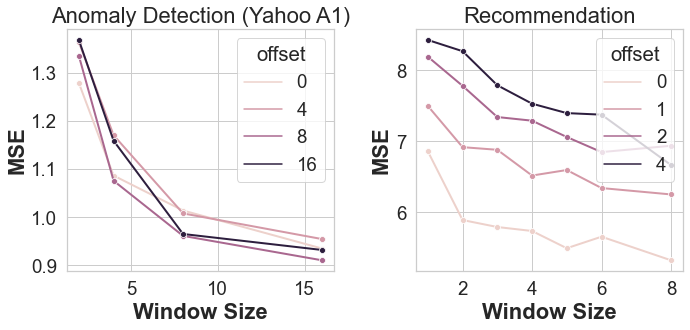

In [263]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
linewidth = 2


# plot ALS 
g1 = sns.lineplot(
    data=als_error_df[(als_error_df["offset"].isin([0, 1, 2,4])) & (als_error_df["window_size"].isin([1, 2, 3, 4, 5, 6, 8]))], 
    marker="o", y="mse", x="window_size", hue="offset", ax=axes[1], linewidth=linewidth
)
#sns.lineplot(
#    data=als_error_df[(als_error_df["offset"] == 0) & (als_error_df["window_size"].isin([1, 2, 3, 4, 5, 6, 7, 8, 16]))], 
#    marker="o", y="baseline_mse", x="window_size", ax=axes[1], linewidth=linewidth, label="Baseline (offset 0)"
#)                                                                                                


axes[1].set_xlabel("Window Size", fontsize=22, fontweight="bold")
axes[1].set_ylabel("MSE", fontsize=22, fontweight="bold")
axes[1].set_title("Recommendation", fontsize=22)

# plot STL 
stl_error_df = window_error_df
g0 = sns.lineplot(data=stl_error_df[(stl_error_df.offset.isin([0, 4, 8, 16])) & (stl_error_df.window_size.isin([2, 4, 8, 16]))], marker="o", y="mse", x="window_size", hue="offset", ax=axes[0], linewidth=linewidth)                                                                                                
#sns.lineplot(data=stl_error_df[stl_error_df["offset"] == 0], marker="o", y="baseline_mse", x="window_size", ax=axes[0], linewidth=linewidth, label="Baseline (offset 0)")                                                                                                

axes[0].set_xlabel("Window Size", fontsize=22, fontweight="bold")
axes[0].set_ylabel("MSE", fontsize=22, fontweight="bold")
axes[0].set_title("Anomaly Detection (Yahoo A1)", fontsize=22)

# Add legends based on the "legend_label:" comments
#handles, labels = axes.get_legend_handles_labels()
#print(handles, labels)
#axes.legend(handles, labels)

fig.tight_layout()

fig.savefig(f'{plots_dir}/predict_error.pdf', dpi=300, bbox_inches = "tight")


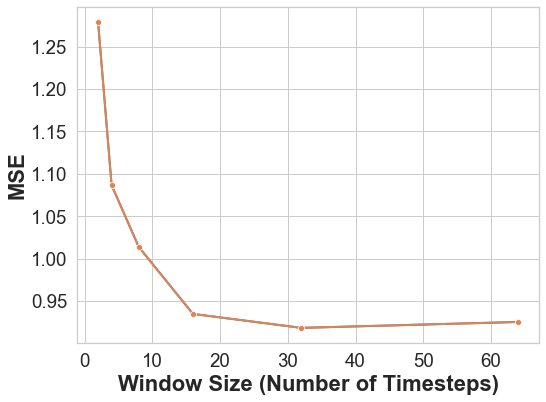

In [193]:
fig, axes = plt.subplots(1, 1, figsize=(8,6))
linewidth = 2

data_df = window_error_df
sns.lineplot(data=data_df[data_df["offset"] == 0], marker="o", y="mse", x="window_size", axes=axes, linewidth=linewidth)                                                                                                
sns.lineplot(data=data_df[data_df["offset"] == 0], marker="o", y="baseline_mse", x="window_size", axes=axes, linewidth=linewidth)                                                                                                

axes.set_xlabel("Window Size (Number of Timesteps)", fontsize=22, fontweight="bold")
axes.set_ylabel("MSE", fontsize=22, fontweight="bold")

fig.tight_layout()

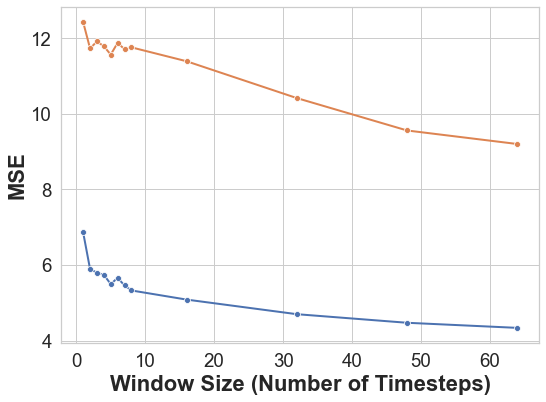

In [147]:
fig, axes = plt.subplots(1, 1, figsize=(8,6))
linewidth = 2

data_df = window_error_df
sns.lineplot(data=als_error_df[als_error_df["offset"] == 0], marker="o", y="mse", x="window_size", axes=axes, linewidth=linewidth)                                                                                                
sns.lineplot(data=als_error_df[als_error_df["offset"] == 0], marker="o", y="baseline_mse", x="window_size", axes=axes, linewidth=linewidth)                                                                                                

axes.set_xlabel("Window Size (Number of Timesteps)", fontsize=22, fontweight="bold")
axes.set_ylabel("MSE", fontsize=22, fontweight="bold")

fig.tight_layout()

In [173]:
window_error_df

""
